# The Very Basics of Musical Instruments Classification using Machine Learning
## Short-Time Fourier Transform (STFT) and Convolutional Neural Networks (CNN) 

<br>

<p align="left">
<img src="./img/businesscard.jpg" width="300px" alt="Business Card" align="left" >
</p>
<br>



## Imports

In [4]:
# Imports

#General
import numpy as np
import itertools

# System
import os, fnmatch

# Data
import pandas as pd

# Visualization
import seaborn 
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display, Image

# Machine Learning
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report


# Deep Learning
import tensorflow as tf
from tensorflow.python.client import device_lib 
from keras.backend.tensorflow_backend import set_session
from tensorflow.python.client import device_lib
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, merge
from keras.layers.normalization import BatchNormalization
from keras.callbacks import History, EarlyStopping, ModelCheckpoint
from keras.models import load_model


# Random Seed
from numpy.random import seed
seed(0)
tf.random.set_seed(0)

# Audio
import librosa.display, librosa
from librosa.util import normalize as normalize
import IPython.display as ipd

# Configurations
path='./audio/london_phill_dataset_multi/'

# Display CPUs and GPUs
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11307063481562444071
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2381688140251184694
physical_device_desc: "device: XLA_CPU device"
]


## Configurations for Google Colab

In [5]:
# Only for Google Colab
try:
    import google.colab
    if "GPU:0" in tf.test.gpu_device_name():
        !nvidia-smi
        config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True, device_count = {'GPU': 0})
        config.gpu_options.allow_growth = True
        session = tf.Session(config=config)
        set_session(session)
    else:
        print("No GPU Detected. Configure the Runtime.")
    !git clone https://github.com/GuitarsAI/BasicsMusicalInstrumClassifi
    !unzip ./BasicsMusicalInstrumClassifi/audio/*.zip -d ./BasicsMusicalInstrumClassifi/audio
    path="./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/"
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    tf.logging.set_verbosity(tf.logging.ERROR)
    from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
    
except Exception as e:
    print("Not inside Google Colab: %s. Using standard configurations." % (e))
    !cat /proc/cpuinfo
 

Not inside Google Colab: No module named 'google.colab'. Using standard configurations.
cat: /proc/cpuinfo: No such file or directory


## Parameters

In [6]:
# Signal Processing Parameters
fs = 44100         # Sampling Frequency
n_fft = 2048       # length of the FFT window
hop_length = 512   # Number of samples between successive frames


# Machine Learning Parameters
testset_size = 0.25 #Percentage of data for Testing


## Aux Functions

In [7]:
# Function to Display a Website
display(HTML("<style>.container { width:80% !important; }</style>"))
def show_web(url):
    html_code='<center><iframe src="%s" width="800" height="600" frameborder="0" marginheight="0" marginwidth="0">Loading...</iframe></center>' \
		% (url)
    display(HTML(html_code))

## Find Audio Files, Generate Labels and Get Duration

In [8]:
#Find Audio Files
files = []
labels =[]
duration = []
classes=['flute','sax','oboe', 'cello','trumpet','viola']
for root, dirnames, filenames in os.walk(path):
    for i, filename in enumerate(fnmatch.filter(filenames, '*.mp3')):
        files.append(os.path.join(root, filename))
        for name in classes:
            if fnmatch.fnmatchcase(filename, '*'+name+'*'):
                labels.append(name)
                break
        else:
            labels.append('other')
        print ("Get %d = %s"%(i+1, filename))
        try:
            y, sr = librosa.load(files[i], sr=fs)
            if len(y) < 2:
                print("Error loading %s" % filename)
                continue
            #y/=y.max() #Normalize
            yt, index = librosa.effects.trim(y,top_db=60) #Trim
            duration.append(librosa.get_duration(yt, sr=fs))
        except Exception as e:
            print("Error loading %s. Error: %s" % (filename,e))


print("found %d audio files in %s"%(len(files),path))

Get 1 = cello_Gs5_025_mezzo-piano_arco-normal.mp3
Get 2 = cello_A4_1_forte_arco-normal.mp3
Get 3 = cello_Gs4_025_fortissimo_arco-normal.mp3
Get 4 = cello_Gs5_025_forte_arco-normal.mp3
Get 5 = cello_A3_025_fortissimo_arco-normal.mp3
Get 6 = cello_Gs3_05_pianissimo_arco-normal.mp3
Get 7 = cello_A3_1_mezzo-piano_arco-normal.mp3
Get 8 = cello_Gs5_1_mezzo-piano_arco-normal.mp3
Get 9 = cello_Gs2_025_pianissimo_arco-normal.mp3
Get 10 = cello_Gs3_05_fortissimo_arco-normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 11 = cello_Gs3_1_pianissimo_arco-normal.mp3
Get 12 = cello_A4_025_mezzo-piano_arco-normal.mp3
Get 13 = cello_Gs4_025_pianissimo_arco-normal.mp3
Get 14 = cello_A3_025_pianissimo_arco-normal.mp3
Get 15 = cello_Gs4_1_forte_arco-normal.mp3
Get 16 = cello_A4_1_pianissimo_arco-normal.mp3
Get 17 = cello_Gs5_15_pianissimo_arco-normal.mp3
Get 18 = cello_A2_15_piano_arco-normal.mp3
Get 19 = cello_Gs5_15_mezzo-piano_arco-normal.mp3
Get 20 = cello_A4_1_mezzo-piano_arco-normal.mp3
Get 21 = cello_A4_15_mezzo-piano_arco-normal.mp3
Get 22 = cello_A2_05_pianissimo_arco-normal.mp3
Get 23 = cello_A4_025_mezzo-forte_arco-col-legno-battuto.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 24 = cello_Gs4_05_pianissimo_arco-normal.mp3
Get 25 = cello_A2_15_forte_arco-normal.mp3
Get 26 = cello_A2_05_fortissimo_arco-normal.mp3
Get 27 = cello_Gs4_05_fortissimo_arco-normal.mp3
Get 28 = cello_Gs3_05_forte_arco-normal.mp3
Get 29 = cello_A4_1_fortissimo_arco-normal.mp3
Get 30 = cello_Gs5_15_fortissimo_arco-normal.mp3
Get 31 = cello_A3_05_forte_arco-normal.mp3
Get 32 = cello_Gs3_15_piano_arco-normal.mp3
Get 33 = cello_A3_15_forte_arco-normal.mp3
Get 34 = cello_Gs3_15_fortissimo_arco-normal.mp3
Get 35 = cello_Gs3_025_fortissimo_arco-normal.mp3
Get 36 = cello_A4_025_fortissimo_arco-normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 37 = cello_Gs5_025_fortissimo_arco-normal.mp3
Get 38 = cello_Gs3_15_forte_arco-normal.mp3
Get 39 = cello_A2_025_fortissimo_arco-normal.mp3
Get 40 = cello_A2_1_pianissimo_arco-normal.mp3
Get 41 = cello_A3_025_forte_arco-normal.mp3
Get 42 = cello_Gs4_025_mezzo-forte_arco-col-legno-battuto.mp3
Get 43 = cello_Gs5_025_pianissimo_arco-normal.mp3
Get 44 = cello_A2_1_mezzo-piano_arco-normal.mp3
Get 45 = cello_Gs4_1_mezzo-piano_arco-normal.mp3
Get 46 = cello_A2_05_forte_arco-normal.mp3
Get 47 = cello_A2_1_fortissimo_arco-normal.mp3
Get 48 = cello_A4_05_pianissimo_arco-normal.mp3
Get 49 = cello_A2_025_pianissimo_arco-normal.mp3
Get 50 = cello_A3_1_forte_arco-normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 51 = cello_Gs3_15_pianissimo_arco-normal.mp3
Get 52 = cello_Gs3_025_pianissimo_arco-normal.mp3
Get 53 = cello_A4_025_pianissimo_arco-normal.mp3
Get 54 = cello_Gs5_1_fortissimo_arco-normal.mp3
Get 55 = cello_Gs4_15_fortissimo_arco-normal.mp3
Get 56 = cello_A3_05_fortissimo_arco-normal.mp3
Get 57 = cello_A3_15_mezzo-piano_arco-normal.mp3
Get 58 = cello_Gs5_05_fortissimo_arco-normal.mp3
Get 59 = cello_Gs4_15_mezzo-piano_arco-normal.mp3
Get 60 = cello_A2_025_mezzo-piano_arco-normal.mp3
Get 61 = cello_A4_025_forte_arco-normal.mp3
Get 62 = cello_Gs5_05_pianissimo_arco-normal.mp3
Get 63 = cello_Gs3_025_mezzo-piano_arco-normal.mp3
Get 64 = cello_Gs3_1_mezzo-piano_arco-normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 65 = cello_Gs3_1_forte_arco-normal.mp3
Get 66 = cello_Gs5_1_pianissimo_arco-normal.mp3
Get 67 = cello_A2_15_pianissimo_arco-normal.mp3
Get 68 = cello_Gs4_15_pianissimo_arco-normal.mp3
Get 69 = cello_A3_1_mezzo-piano_non-vibrato.mp3
Get 70 = cello_Gs4_05_mezzo-piano_arco-normal.mp3
Get 71 = cello_A3_025_mezzo-forte_arco-col-legno-battuto.mp3
Get 72 = cello_A4_05_forte_arco-normal.mp3
Get 73 = cello_A3_05_mezzo-piano_arco-normal.mp3
Get 74 = cello_A3_1_mezzo-piano_arco-minor-trill.mp3
Get 75 = cello_Gs4_05_forte_arco-normal.mp3
Get 76 = cello_Gs5_1_mezzo-forte_arco-harmonic.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 77 = cello_Gs4_1_fortissimo_arco-normal.mp3
Get 78 = cello_Gs4_1_pianissimo_arco-normal.mp3
Get 79 = cello_A4_1_mezzo-forte_arco-harmonic.mp3
Get 80 = cello_Gs5_1_forte_arco-normal.mp3
Get 81 = cello_Gs5_15_forte_arco-normal.mp3
Get 82 = cello_A3_1_pianissimo_arco-normal.mp3
Get 83 = cello_A3_025_mezzo-piano_arco-normal.mp3
Get 84 = cello_A2_025_forte_arco-normal.mp3
Get 85 = cello_A3_1_fortissimo_arco-normal.mp3
Get 86 = cello_Gs3_025_forte_arco-normal.mp3
Get 87 = cello_Gs3_05_mezzo-piano_arco-normal.mp3
Get 88 = cello_A2_025_mezzo-forte_arco-col-legno-battuto.mp3
Get 89 = cello_A4_05_mezzo-piano_arco-normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 90 = cello_Gs5_05_mezzo-piano_arco-normal.mp3
Get 91 = cello_A2_05_mezzo-piano_arco-normal.mp3
Get 92 = cello_A4_1_mezzo-piano_molto-vibrato.mp3
Get 93 = cello_Gs4_025_mezzo-piano_arco-normal.mp3
Get 94 = cello_A2_1_mezzo-piano_non-vibrato.mp3
Get 95 = cello_Gs5_05_forte_arco-normal.mp3
Get 96 = cello_A2_1_forte_arco-normal.mp3
Get 97 = cello_Gs4_15_forte_arco-normal.mp3
Get 98 = cello_A4_1_mezzo-piano_arco-minor-trill.mp3
Get 99 = cello_A4_15_forte_arco-normal.mp3
Get 100 = cello_Gs4_025_forte_arco-normal.mp3
Get 1 = saxophone_Gs3_025_forte_normal.mp3
Get 2 = saxophone_Gs5_15_pianissimo_normal.mp3
Get 3 = saxophone_A4_15_piano_normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 4 = saxophone_A4_025_fortissimo_normal.mp3
Get 5 = saxophone_Ds4_05_mezzo-forte_normal.mp3
Get 6 = saxophone_Ds5_1_forte_major-trill.mp3
Get 7 = saxophone_Gs4_05_pianissimo_normal.mp3
Get 8 = saxophone_A3_15_pianissimo_normal.mp3
Get 9 = saxophone_Gs5_1_piano_normal.mp3
Get 10 = saxophone_A3_05_piano_normal.mp3
Get 11 = saxophone_Ds4_025_mezzo-forte_normal.mp3
Get 12 = saxophone_Ds5_1_forte_minor-trill.mp3
Get 13 = saxophone_Ds4_05_mezzo-forte_slap-tongue.mp3
Get 14 = saxophone_A5_1_forte_normal.mp3
Get 15 = saxophone_A5_05_piano_normal.mp3
Get 16 = saxophone_A5_15_fortissimo_normal.mp3
Get 17 = saxophone_Ds4_15_fortissimo_normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 18 = saxophone_Gs5_1_fortissimo_normal.mp3
Get 19 = saxophone_Gs3_1_pianissimo_normal.mp3
Get 20 = saxophone_A4_05_piano_normal.mp3
Get 21 = saxophone_A3_1_piano_normal.mp3
Get 22 = saxophone_A4_025_forte_normal.mp3
Get 23 = saxophone_Gs4_025_mezzo-forte_normal.mp3
Get 24 = saxophone_A4_05_fortissimo_normal.mp3
Get 25 = saxophone_Gs3_15_fortissimo_normal.mp3
Get 26 = saxophone_A3_025_fortissimo_normal.mp3
Get 27 = saxophone_A4_1_fortissimo_normal.mp3
Get 28 = saxophone_Ds4_025_pianissimo_normal.mp3
Get 29 = saxophone_A5_15_forte_normal.mp3
Get 30 = saxophone_A4_15_forte_normal.mp3
Get 31 = saxophone_A4_15_fortissimo_normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 32 = saxophone_Gs3_05_fortissimo_normal.mp3
Get 33 = saxophone_Ds4_05_pianissimo_subtone.mp3
Get 34 = saxophone_Gs3_025_mezzo-piano_normal.mp3
Get 35 = saxophone_Gs5_1_forte_normal.mp3
Get 36 = saxophone_Gs4_025_fortissimo_normal.mp3
Get 37 = saxophone_A3_05_forte_normal.mp3
Get 38 = saxophone_Ds4_05_fortissimo_normal.mp3
Get 39 = saxophone_Ds4_05_piano_normal.mp3
Get 40 = saxophone_A5_1_piano_normal.mp3
Get 41 = saxophone_A5_05_fortissimo_normal.mp3
Get 42 = saxophone_Gs3_1_piano_normal.mp3
Get 43 = saxophone_A5_05_forte_normal.mp3
Get 44 = saxophone_A4_05_forte_normal.mp3
Get 45 = saxophone_Gs3_025_fortissimo_normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 46 = saxophone_A3_1_forte_normal.mp3
Get 47 = saxophone_A4_025_piano_normal.mp3
Get 48 = saxophone_Gs4_15_pianissimo_normal.mp3
Get 49 = saxophone_A3_05_pianissimo_normal.mp3
Get 50 = saxophone_A5_1_pianissimo_normal.mp3
Get 51 = saxophone_A3_1_fortissimo_normal.mp3
Get 52 = saxophone_Gs4_1_pianissimo_normal.mp3
Get 53 = saxophone_A3_15_forte_normal.mp3
Get 54 = saxophone_A3_025_mezzo-piano_normal.mp3
Get 55 = saxophone_Gs5_05_pianissimo_normal.mp3
Get 56 = saxophone_Gs4_15_forte_normal.mp3
Get 57 = saxophone_Gs3_05_mezzo-piano_normal.mp3
Get 58 = saxophone_A3_025_forte_normal.mp3
Get 59 = saxophone_A3_1_pianissimo_normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 60 = saxophone_A5_1_fortissimo_normal.mp3
Get 61 = saxophone_Gs4_15_fortissimo_normal.mp3
Get 62 = saxophone_A3_05_fortissimo_normal.mp3
Get 63 = saxophone_Gs5_15_forte_normal.mp3
Get 64 = saxophone_Gs3_05_forte_normal.mp3
Get 65 = saxophone_Ds4_025_forte_normal.mp3
Get 66 = saxophone_Gs4_1_fortissimo_normal.mp3
Get 67 = saxophone_Gs5_05_fortissimo_normal.mp3
Get 68 = saxophone_Gs4_05_forte_normal.mp3
Get 69 = saxophone_Ds4_025_fortissimo_normal.mp3
Get 70 = saxophone_Gs4_025_forte_normal.mp3
Get 71 = saxophone_Gs5_05_forte_normal.mp3
Get 72 = saxophone_Gs3_05_pianissimo_normal.mp3
Get 73 = saxophone_Gs5_025_fortissimo_normal.mp3
Get 74 = saxophone_Gs4_025_pianissimo_normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 75 = saxophone_Gs5_025_piano_normal.mp3
Get 76 = saxophone_A4_1_piano_normal.mp3
Get 77 = saxophone_A5_05_pianissimo_normal.mp3
Get 78 = saxophone_Ds4_05_pianissimo_normal.mp3
Get 79 = saxophone_Gs4_1_forte_normal.mp3
Get 80 = saxophone_Gs4_15_piano_normal.mp3
Get 81 = saxophone_A5_15_pianissimo_normal.mp3
Get 82 = saxophone_Gs5_15_piano_normal.mp3
Get 83 = saxophone_Gs5_1_pianissimo_normal.mp3
Get 84 = saxophone_A4_1_pianissimo_normal.mp3
Get 85 = saxophone_Gs3_05_piano_normal.mp3
Get 86 = saxophone_A3_025_pianissimo_normal.mp3
Get 87 = saxophone_A4_05_pianissimo_normal.mp3
Get 88 = saxophone_Gs3_15_pianissimo_normal.mp3
Get 89 = saxophone_A3_05_mezzo-piano_normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 90 = saxophone_Gs4_05_piano_normal.mp3
Get 91 = saxophone_Gs5_15_fortissimo_normal.mp3
Get 92 = saxophone_Gs4_025_piano_normal.mp3
Get 93 = saxophone_Gs5_05_piano_normal.mp3
Get 94 = saxophone_Gs5_025_forte_normal.mp3
Get 95 = saxophone_A4_1_mezzo-forte_normal.mp3
Get 96 = saxophone_A4_1_forte_normal.mp3
Get 97 = saxophone_Gs4_05_fortissimo_normal.mp3
Get 98 = saxophone_A3_15_fortissimo_normal.mp3
Get 99 = saxophone_Gs4_1_piano_normal.mp3
Get 100 = saxophone_Gs4_05_mezzo-forte_normal.mp3
Get 1 = oboe_A5_15_fortissimo_normal.mp3
Get 2 = oboe_Gs4_05_mezzo-forte_normal.mp3
Get 3 = oboe_A4_1_fortissimo_normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 4 = oboe_Gs6_15_forte_normal.mp3
Get 5 = oboe_Gs5_1_forte_normal.mp3
Get 6 = oboe_A4_1_forte_normal.mp3
Get 7 = oboe_Gs5_1_fortissimo_normal.mp3
Get 8 = oboe_Gs4_15_forte_normal.mp3
Get 9 = oboe_Gs5_1_mezzo-forte_normal.mp3
Get 10 = oboe_A4_05_fortissimo_normal.mp3
Get 11 = oboe_A5_05_mezzo-forte_normal.mp3
Get 12 = oboe_A4_15_forte_normal.mp3
Get 13 = oboe_Gs5_15_forte_normal.mp3
Get 14 = oboe_A5_15_forte_normal.mp3
Get 15 = oboe_A5_1_forte_major-trill.mp3
Get 16 = oboe_Gs6_05_forte_normal.mp3
Get 17 = oboe_As3_15_fortissimo_normal.mp3
Get 18 = oboe_Gs5_025_forte_normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 19 = oboe_G6_025_piano_normal.mp3
Get 20 = oboe_As3_1_fortissimo_normal.mp3
Get 21 = oboe_Gs4_1_forte_major-trill.mp3
Get 22 = oboe_Gs5_025_mezzo-forte_normal.mp3
Get 23 = oboe_Gs4_05_forte_normal.mp3
Get 24 = oboe_Gs6_1_forte_normal.mp3
Get 25 = oboe_A4_05_forte_normal.mp3
Get 26 = oboe_A5_1_forte_minor-trill.mp3
Get 27 = oboe_As3_05_piano_normal.mp3
Get 28 = oboe_Gs5_05_forte_normal.mp3
Get 29 = oboe_Gs4_1_forte_minor-trill.mp3
Get 30 = oboe_Gs4_025_piano_normal.mp3
Get 31 = oboe_A5_05_forte_normal.mp3
Get 32 = oboe_Gs6_05_mezzo-forte_normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 33 = oboe_A6_15_piano_normal.mp3
Get 34 = oboe_A4_025_fortissimo_normal.mp3
Get 35 = oboe_Gs5_15_mezzo-forte_normal.mp3
Get 36 = oboe_Gs6_15_piano_normal.mp3
Get 37 = oboe_A6_1_forte_minor-trill.mp3
Get 38 = oboe_A4_1_piano_normal.mp3
Get 39 = oboe_Gs5_1_piano_normal.mp3
Get 40 = oboe_Gs4_025_mezzo-forte_normal.mp3
Get 41 = oboe_Gs4_15_piano_normal.mp3
Get 42 = oboe_A6_025_piano_normal.mp3
Get 43 = oboe_Gs5_025_fortissimo_normal.mp3
Get 44 = oboe_A4_15_piano_normal.mp3
Get 45 = oboe_A6_1_forte_major-trill.mp3
Get 46 = oboe_As3_05_fortissimo_normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 47 = oboe_Gs5_15_piano_normal.mp3
Get 48 = oboe_As3_15_forte_normal.mp3
Get 49 = oboe_A5_15_piano_normal.mp3
Get 50 = oboe_A6_05_piano_normal.mp3
Get 51 = oboe_Gs6_05_piano_normal.mp3
Get 52 = oboe_As3_15_mezzo-forte_normal.mp3
Get 53 = oboe_G6_025_forte_normal.mp3
Get 54 = oboe_Gs5_025_piano_normal.mp3
Get 55 = oboe_Gs4_05_piano_normal.mp3
Get 56 = oboe_Gs6_1_piano_normal.mp3
Get 57 = oboe_A4_05_piano_normal.mp3
Get 58 = oboe_As3_05_forte_normal.mp3
Get 59 = oboe_Gs5_05_piano_normal.mp3
Get 60 = oboe_Gs4_1_mezzo-forte_normal.mp3
Get 61 = oboe_A5_05_fortissimo_normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 62 = oboe_A5_05_piano_normal.mp3
Get 63 = oboe_Gs4_025_forte_normal.mp3
Get 64 = oboe_Gs6_025_mezzo-forte_normal.mp3
Get 65 = oboe_As3_1_forte_normal.mp3
Get 66 = oboe_Gs6_025_piano_normal.mp3
Get 67 = oboe_A5_025_mezzo-forte_normal.mp3
Get 68 = oboe_A6_1_piano_normal.mp3
Get 69 = oboe_As3_1_mezzo-forte_normal.mp3
Get 70 = oboe_Gs6_1_mezzo-forte_normal.mp3
Get 71 = oboe_A5_1_piano_normal.mp3
Get 72 = oboe_Gs4_1_piano_normal.mp3
Get 73 = oboe_A5_15_mezzo-forte_normal.mp3
Get 74 = oboe_A5_025_piano_normal.mp3
Get 75 = oboe_Gs4_025_fortissimo_normal.mp3
Get 76 = oboe_Gs5_15_fortissimo_normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 77 = oboe_Ds6_05_mezzo-forte_normal.mp3
Get 78 = oboe_Gs4_1_fortissimo_normal.mp3
Get 79 = oboe_Gs4_05_fortissimo_normal.mp3
Get 80 = oboe_A5_1_mezzo-forte_normal.mp3
Get 81 = oboe_Ds6_15_forte_normal.mp3
Get 82 = oboe_A5_1_fortissimo_normal.mp3
Get 83 = oboe_A4_025_forte_normal.mp3
Get 84 = oboe_Gs4_15_mezzo-forte_normal.mp3
Get 85 = oboe_A5_025_fortissimo_normal.mp3
Get 86 = oboe_Gs4_15_fortissimo_normal.mp3
Get 87 = oboe_Ds6_05_fortissimo_normal.mp3
Get 88 = oboe_As3_1_piano_normal.mp3
Get 89 = oboe_G6_025_mezzo-forte_normal.mp3
Get 90 = oboe_Gs6_025_forte_normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 91 = oboe_Gs5_05_fortissimo_normal.mp3
Get 92 = oboe_A4_1_mezzo-forte_normal.mp3
Get 93 = oboe_As3_05_mezzo-forte_normal.mp3
Get 94 = oboe_Ds6_05_piano_normal.mp3
Get 95 = oboe_Gs4_1_forte_normal.mp3
Get 96 = oboe_A5_1_forte_normal.mp3
Get 97 = oboe_A5_025_forte_normal.mp3
Get 98 = oboe_Gs5_05_mezzo-forte_normal.mp3
Get 99 = oboe_A4_025_piano_normal.mp3
Get 100 = oboe_Gs6_15_mezzo-forte_normal.mp3
Get 1 = trumpet_As5_05_mezzo-forte_normal.mp3
Get 2 = trumpet_Ds6_025_forte_normal.mp3
Get 3 = trumpet_A3_025_pianissimo_normal.mp3
Get 4 = trumpet_F4_025_pianissimo_normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 5 = trumpet_Gs3_15_pianissimo_normal.mp3
Get 6 = trumpet_Cs4_05_forte_normal.mp3
Get 7 = trumpet_E6_1_forte_normal.mp3
Get 8 = trumpet_Cs4_025_pianissimo_normal.mp3
Get 9 = trumpet_F3_05_pianissimo_normal.mp3
Get 10 = trumpet_E4_05_pianissimo_normal.mp3
Get 11 = trumpet_Cs6_025_forte_normal.mp3
Get 12 = trumpet_D4_025_forte_normal.mp3
Get 13 = trumpet_G3_1_pianissimo_normal.mp3
Get 14 = trumpet_B3_05_forte_normal.mp3
Get 15 = trumpet_Ds4_15_pianissimo_normal.mp3
Get 16 = trumpet_G5_1_mezzo-forte_normal.mp3
Get 17 = trumpet_Cs4_15_pianissimo_normal.mp3
Get 18 = trumpet_As3_05_pianissimo_normal.mp3
Get 19 = trumpet_E6_025_forte_normal.mp3
Get 20 = trumpet_As5_05_forte_normal.mp3
Get 21 = trumpet_A3_05_pianissimo_normal.mp3
Get 22 = trumpet_F3_025_pianissimo_normal.mp3
Get 23 = trumpet_B5_025_forte_normal.mp3
Get 24 = trumpet_E3_1_forte_normal.mp3
Get 25 = trumpet_F3_05_forte_normal.mp3
Get 26 = trumpet_C4_1_pianissimo_normal.mp3
Get 27 = trumpet_G3_025_pianissimo_normal.mp3
Get 28 = 

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 32 = trumpet_Gs5_05_forte_normal.mp3
Get 33 = trumpet_Cs4_05_pianissimo_normal.mp3
Get 34 = trumpet_Gs4_05_forte_normal.mp3
Get 35 = trumpet_F3_1_forte_normal.mp3
Get 36 = trumpet_G5_025_mezzo-forte_normal.mp3
Get 37 = trumpet_G5_15_mezzo-forte_normal.mp3
Get 38 = trumpet_Ds4_05_pianissimo_normal.mp3
Get 39 = trumpet_Gs3_025_pianissimo_normal.mp3
Get 40 = trumpet_Gs3_1_pianissimo_normal.mp3
Get 41 = trumpet_C6_05_forte_normal.mp3
Get 42 = trumpet_Gs3_05_forte_normal.mp3
Get 43 = trumpet_B4_025_forte_normal.mp3
Get 44 = trumpet_F3_15_pianissimo_normal.mp3
Get 45 = trumpet_E4_15_pianissimo_normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 46 = trumpet_B5_025_mezzo-forte_normal.mp3
Get 47 = trumpet_B3_1_pianissimo_normal.mp3
Get 48 = trumpet_Gs3_05_pianissimo_normal.mp3
Get 49 = trumpet_F3_1_pianissimo_normal.mp3
Get 50 = trumpet_C4_05_forte_normal.mp3
Get 51 = trumpet_A5_05_mezzo-forte_normal.mp3
Get 52 = trumpet_A5_025_mezzo-forte_normal.mp3
Get 53 = trumpet_A5_025_forte_normal.mp3
Get 54 = trumpet_Ds4_1_pianissimo_normal.mp3
Get 55 = trumpet_As3_025_pianissimo_normal.mp3
Get 56 = trumpet_E4_1_pianissimo_normal.mp3
Get 57 = trumpet_B3_05_pianissimo_normal.mp3
Get 58 = trumpet_D4_15_pianissimo_normal.mp3
Get 59 = trumpet_G3_15_pianissimo_normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 60 = trumpet_E3_025_pianissimo_normal.mp3
Get 61 = trumpet_F3_025_forte_normal.mp3
Get 62 = trumpet_Gs3_1_forte_normal.mp3
Get 63 = trumpet_Gs4_025_forte_normal.mp3
Get 64 = trumpet_Gs5_025_mezzo-forte_normal.mp3
Get 65 = trumpet_B3_025_pianissimo_normal.mp3
Get 66 = trumpet_Ds4_025_pianissimo_normal.mp3
Get 67 = trumpet_E4_025_pianissimo_normal.mp3
Get 68 = trumpet_As5_025_forte_normal.mp3
Get 69 = trumpet_E3_05_pianissimo_normal.mp3
Get 70 = trumpet_F4_05_pianissimo_normal.mp3
Get 71 = trumpet_C4_15_pianissimo_normal.mp3
Get 72 = trumpet_As3_1_pianissimo_normal.mp3
Get 73 = trumpet_Cs4_1_pianissimo_normal.mp3
Get 74 = trumpet_D6_025_forte_normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 75 = trumpet_E3_05_forte_normal.mp3
Get 76 = trumpet_A3_1_pianissimo_normal.mp3
Get 77 = trumpet_D4_025_pianissimo_normal.mp3
Get 78 = trumpet_B3_025_forte_normal.mp3
Get 79 = trumpet_Gs5_025_forte_normal.mp3
Get 80 = trumpet_E3_1_pianissimo_normal.mp3
Get 81 = trumpet_D6_05_forte_normal.mp3
Get 82 = trumpet_A4_025_forte_normal.mp3
Get 83 = trumpet_A4_05_forte_normal.mp3
Get 84 = trumpet_D5_05_forte_normal.mp3
Get 85 = trumpet_C4_05_pianissimo_normal.mp3
Get 86 = trumpet_E3_15_pianissimo_normal.mp3
Get 87 = trumpet_D4_05_forte_normal.mp3
Get 88 = trumpet_G5_05_mezzo-forte_normal.mp3
Get 89 = trumpet_Gs5_05_mezzo-forte_normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 90 = trumpet_Ds4_05_forte_normal.mp3
Get 91 = trumpet_A3_05_forte_normal.mp3
Get 92 = trumpet_D4_05_pianissimo_normal.mp3
Get 93 = trumpet_Ds5_05_forte_normal.mp3
Get 94 = trumpet_G3_05_pianissimo_normal.mp3
Get 95 = trumpet_B3_15_pianissimo_normal.mp3
Get 96 = trumpet_As4_025_forte_normal.mp3
Get 97 = trumpet_Ds6_05_forte_normal.mp3
Get 98 = trumpet_C4_025_forte_normal.mp3
Get 99 = trumpet_D4_1_pianissimo_normal.mp3
Get 100 = trumpet_C4_025_pianissimo_normal.mp3
Get 1 = viola_A3_05_mezzo-piano_arco-normal.mp3
Get 2 = viola_Gs5_05_piano_arco-normal.mp3
Get 3 = viola_A4_1_mezzo-forte_molto-vibrato.mp3
Get 4 = viola_Gs3_025_fortissimo_arco-normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 5 = viola_Gs6_05_fortissimo_arco-normal.mp3
Get 6 = viola_Gs5_05_forte_arco-normal.mp3
Get 7 = viola_Gs5_025_fortissimo_arco-normal.mp3
Get 8 = viola_A4_1_mezzo-forte_arco-major-trill.mp3
Get 9 = viola_Gs6_05_pianissimo_arco-normal.mp3
Get 10 = viola_Gs6_025_forte_arco-normal.mp3
Get 11 = viola_Gs5_025_pianissimo_arco-normal.mp3
Get 12 = viola_Gs6_025_piano_arco-normal.mp3
Get 13 = viola_Gs3_025_pianissimo_arco-normal.mp3
Get 14 = viola_A4_1_mezzo-forte_arco-minor-trill.mp3
Get 15 = viola_Gs5_1_fortissimo_snap-pizz.mp3
Get 16 = viola_Gs4_15_mezzo-piano_arco-normal.mp3
Get 17 = viola_Gs6_1_forte_arco-normal.mp3
Get 18 = viola_A3_1_fortissimo_arco-normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 19 = viola_A4_15_piano_arco-normal.mp3
Get 20 = viola_A3_1_pianissimo_arco-normal.mp3
Get 21 = viola_A4_05_mezzo-piano_arco-normal.mp3
Get 22 = viola_A5_1_fortissimo_arco-normal.mp3
Get 23 = viola_A4_05_forte_arco-normal.mp3
Get 24 = viola_A3_1_mezzo-piano_non-vibrato.mp3
Get 25 = viola_Gs4_025_fortissimo_arco-normal.mp3
Get 26 = viola_Ds3_1_piano_pizz-normal.mp3
Get 27 = viola_A4_05_piano_arco-normal.mp3
Get 28 = viola_Gs4_1_fortissimo_arco-normal.mp3
Get 29 = viola_Gs5_1_piano_arco-normal.mp3
Get 30 = viola_Gs4_1_pianissimo_arco-normal.mp3
Get 31 = viola_Gs6_15_fortissimo_arco-normal.mp3
Get 32 = viola_Gs5_1_forte_arco-normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 33 = viola_A5_1_pianissimo_arco-normal.mp3
Get 34 = viola_Gs4_025_pianissimo_arco-normal.mp3
Get 35 = viola_A4_025_mezzo-piano_arco-normal.mp3
Get 36 = viola_A4_1_mezzo-piano_non-vibrato.mp3
Get 37 = viola_Gs3_025_piano_arco-normal.mp3
Get 38 = viola_A3_1_fortissimo_pizz-normal.mp3
Get 39 = viola_Gs4_05_piano_arco-normal.mp3
Get 40 = viola_A5_1_forte_arco-normal.mp3
Get 41 = viola_Gs4_025_mezzo-piano_arco-normal.mp3
Get 42 = viola_A3_025_fortissimo_arco-normal.mp3
Get 43 = viola_A4_1_fortissimo_snap-pizz.mp3
Get 44 = viola_A5_1_mezzo-forte_artificial-harmonic.mp3
Get 45 = viola_A3_15_forte_arco-normal.mp3
Get 46 = viola_A4_05_fortissimo_arco-normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 47 = viola_Gs6_1_pianissimo_arco-normal.mp3
Get 48 = viola_A4_1_piano_pizz-normal.mp3
Get 49 = viola_A3_15_piano_arco-normal.mp3
Get 50 = viola_A4_025_piano_arco-normal.mp3
Get 51 = viola_Gs6_1_fortissimo_arco-normal.mp3
Get 52 = viola_A4_05_pianissimo_arco-normal.mp3
Get 53 = viola_A3_1_forte_arco-normal.mp3
Get 54 = viola_A3_025_pianissimo_arco-normal.mp3
Get 55 = viola_A3_1_piano_arco-normal.mp3
Get 56 = viola_Gs5_15_pianissimo_arco-normal.mp3
Get 57 = viola_Gs5_1_fortissimo_arco-normal.mp3
Get 58 = viola_Gs4_05_pianissimo_arco-normal.mp3
Get 59 = viola_Gs5_025_forte_arco-normal.mp3
Get 60 = viola_A3_1_mezzo-forte_molto-vibrato.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 61 = viola_Gs5_025_mezzo-piano_arco-normal.mp3
Get 62 = viola_Gs3_15_piano_arco-normal.mp3
Get 63 = viola_A3_05_fortissimo_arco-normal.mp3
Get 64 = viola_A3_025_piano_arco-normal.mp3
Get 65 = viola_A4_1_fortissimo_arco-normal.mp3
Get 66 = viola_Gs6_05_piano_arco-normal.mp3
Get 67 = viola_Gs4_05_fortissimo_arco-normal.mp3
Get 68 = viola_A3_05_pianissimo_arco-normal.mp3
Get 69 = viola_A4_1_pianissimo_arco-normal.mp3
Get 70 = viola_Gs6_05_forte_arco-normal.mp3
Get 71 = viola_Gs5_15_fortissimo_arco-normal.mp3
Get 72 = viola_Gs5_1_pianissimo_arco-normal.mp3
Get 73 = viola_A4_15_pianissimo_arco-normal.mp3
Get 74 = viola_A4_025_fortissimo_arco-normal.mp3
Get 75 = viola_A4_1_piano_arco-normal.mp3
Get 76 = viola_Gs3_15_fortissimo_arco-normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 77 = viola_Gs4_05_mezzo-piano_arco-normal.mp3
Get 78 = viola_A4_1_piano_arco-glissando.mp3
Get 79 = viola_Gs6_15_forte_arco-normal.mp3
Get 80 = viola_Gs6_025_mezzo-piano_arco-normal.mp3
Get 81 = viola_Gs6_025_pianissimo_arco-normal.mp3
Get 82 = viola_A4_1_forte_arco-normal.mp3
Get 83 = viola_Gs6_025_fortissimo_arco-normal.mp3
Get 84 = viola_Gs4_1_mezzo-piano_arco-normal.mp3
Get 85 = viola_A3_1_piano_pizz-normal.mp3
Get 86 = viola_A4_025_pianissimo_arco-normal.mp3
Get 87 = viola_A4_15_fortissimo_arco-normal.mp3
Get 88 = viola_Gs3_15_pianissimo_arco-normal.mp3
Get 89 = viola_Gs3_025_mezzo-piano_arco-normal.mp3
Get 90 = viola_Ds3_05_mezzo-piano_arco-normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 91 = viola_Gs4_15_fortissimo_arco-normal.mp3
Get 92 = viola_Gs5_05_fortissimo_arco-normal.mp3
Get 93 = viola_Gs4_1_piano_arco-normal.mp3
Get 94 = viola_A3_05_piano_arco-normal.mp3
Get 95 = viola_Gs5_05_pianissimo_arco-normal.mp3
Get 96 = viola_A3_025_mezzo-piano_arco-normal.mp3
Get 97 = viola_Ds3_05_fortissimo_arco-normal.mp3
Get 98 = viola_Gs4_15_pianissimo_arco-normal.mp3
Get 99 = viola_A3_1_piano_arco-glissando.mp3
Get 100 = viola_A3_15_fortissimo_arco-normal.mp3
Get 1 = flute_A4_025_piano_normal.mp3
Get 2 = flute_A6_15_forte_normal.mp3
Get 3 = flute_A6_1_fortissimo_minor-trill.mp3
Get 4 = flute_Gs5_1_forte_normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 5 = flute_A5_1_piano_normal.mp3
Get 6 = flute_Gs4_025_pianissimo_normal.mp3
Get 7 = flute_A4_15_forte_normal.mp3
Get 8 = flute_A5_025_pianissimo_normal.mp3
Get 9 = flute_A5_025_forte_normal.mp3
Get 10 = flute_Gs4_05_pianissimo_normal.mp3
Get 11 = flute_Gs5_15_mezzo-forte_normal.mp3
Get 12 = flute_A5_15_forte_normal.mp3
Get 13 = flute_A4_1_mezzo-forte_normal.mp3
Get 14 = flute_A6_1_pianissimo_normal.mp3
Get 15 = flute_Gs5_1_mezzo-piano_normal.mp3
Get 16 = flute_A4_15_mezzo-forte_normal.mp3
Get 17 = flute_Gs6_05_mezzo-forte_normal.mp3
Get 18 = flute_A5_05_mezzo-piano_normal.mp3
Get 19 = flute_Gs4_05_mezzo-piano_normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 20 = flute_Gs5_1_pianissimo_normal.mp3
Get 21 = flute_Gs4_025_forte_normal.mp3
Get 22 = flute_A6_05_forte_normal.mp3
Get 23 = flute_A5_15_pianissimo_normal.mp3
Get 24 = flute_A4_05_forte_normal.mp3
Get 25 = flute_Gs5_025_piano_normal.mp3
Get 26 = flute_A5_1_mezzo-piano_normal.mp3
Get 27 = flute_Gs6_1_forte_normal.mp3
Get 28 = flute_A6_1_piano_normal.mp3
Get 29 = flute_A4_05_pianissimo_normal.mp3
Get 30 = flute_A5_05_forte_normal.mp3
Get 31 = flute_A4_025_forte_normal.mp3
Get 32 = flute_A4_15_pianissimo_normal.mp3
Get 33 = flute_A5_1_forte_normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 34 = flute_Gs6_025_mezzo-forte_normal.mp3
Get 35 = flute_Gs5_1_piano_normal.mp3
Get 36 = flute_A4_15_piano_normal.mp3
Get 37 = flute_Gs6_025_pianissimo_normal.mp3
Get 38 = flute_Gs6_1_pianissimo_normal.mp3
Get 39 = flute_A5_025_piano_normal.mp3
Get 40 = flute_A5_05_pianissimo_normal.mp3
Get 41 = flute_Gs5_15_mezzo-piano_normal.mp3
Get 42 = flute_A4_15_mezzo-piano_normal.mp3
Get 43 = flute_Gs5_1_mezzo-forte_normal.mp3
Get 44 = flute_A5_15_piano_normal.mp3
Get 45 = flute_A4_1_mezzo-piano_normal.mp3
Get 46 = flute_A5_05_mezzo-forte_normal.mp3
Get 47 = flute_Gs4_05_mezzo-forte_normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 48 = flute_Gs4_025_piano_normal.mp3
Get 49 = flute_A6_05_piano_normal.mp3
Get 50 = flute_A5_1_pianissimo_normal.mp3
Get 51 = flute_Gs4_15_pianissimo_normal.mp3
Get 52 = flute_A4_05_piano_normal.mp3
Get 53 = flute_Gs5_025_forte_normal.mp3
Get 54 = flute_A5_1_mezzo-forte_normal.mp3
Get 55 = flute_A6_1_forte_normal.mp3
Get 56 = flute_Gs6_1_piano_normal.mp3
Get 57 = flute_Gs5_05_pianissimo_normal.mp3
Get 58 = flute_A5_05_piano_normal.mp3
Get 59 = flute_A5_025_mezzo-piano_normal.mp3
Get 60 = flute_Gs5_05_piano_normal.mp3
Get 61 = flute_Gs4_025_mezzo-forte_normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 62 = flute_Gs6_025_forte_normal.mp3
Get 63 = flute_Gs4_05_piano_normal.mp3
Get 64 = flute_Gs6_05_piano_normal.mp3
Get 65 = flute_Gs5_025_mezzo-piano_normal.mp3
Get 66 = flute_Gs4_15_mezzo-piano_normal.mp3
Get 67 = flute_A4_025_mezzo-forte_normal.mp3
Get 68 = flute_Gs6_15_mezzo-forte_normal.mp3
Get 69 = flute_A5_15_mezzo-piano_normal.mp3
Get 70 = flute_A4_05_mezzo-forte_normal.mp3
Get 71 = flute_Gs5_15_piano_normal.mp3
Get 72 = flute_A4_1_forte_normal.mp3
Get 73 = flute_Gs5_05_mezzo-forte_normal.mp3
Get 74 = flute_Gs4_15_piano_normal.mp3
Get 75 = flute_Gs6_15_pianissimo_normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 76 = flute_Gs6_15_piano_normal.mp3
Get 77 = flute_Gs4_025_mezzo-piano_normal.mp3
Get 78 = flute_Gs5_05_forte_normal.mp3
Get 79 = flute_A5_025_mezzo-forte_normal.mp3
Get 80 = flute_A6_1_mezzo-forte_normal.mp3
Get 81 = flute_Gs6_025_piano_normal.mp3
Get 82 = flute_Gs6_05_pianissimo_normal.mp3
Get 83 = flute_Gs4_05_forte_normal.mp3
Get 84 = flute_A4_1_pianissimo_normal.mp3
Get 85 = flute_Gs6_05_forte_normal.mp3
Get 86 = flute_A4_025_mezzo-piano_normal.mp3
Get 87 = flute_Gs4_15_mezzo-forte_normal.mp3
Get 88 = flute_Gs5_025_mezzo-forte_normal.mp3
Get 89 = flute_A5_15_mezzo-forte_normal.mp3
Get 90 = flute_Gs5_15_forte_normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 91 = flute_A4_05_mezzo-piano_normal.mp3
Get 92 = flute_A4_1_piano_normal.mp3
Get 93 = flute_A6_05_pianissimo_normal.mp3
Get 94 = flute_Gs5_05_mezzo-piano_normal.mp3
Get 95 = flute_A6_05_mezzo-forte_normal.mp3
Get 96 = flute_Gs6_1_mezzo-forte_normal.mp3
Get 97 = flute_Gs5_025_pianissimo_normal.mp3
Get 98 = flute_A4_025_pianissimo_normal.mp3
Get 99 = flute_Gs4_15_forte_normal.mp3
Get 100 = flute_Gs6_15_forte_normal.mp3
found 600 audio files in ./audio/london_phill_dataset_multi/


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

In [9]:
print("Max. Duration:", max(duration))
print("Min. Duration:", min(duration))
print("Average Duration:", np.mean(duration))

Max. Duration: 2.5861224489795918
Min. Duration: 0.39183673469387753
Average Duration: 1.0982748299319727


## Trim Silence and Recalculate Duration

In [10]:
# Load audio files, trim silence and calculate duration
duration = []
for i,f in enumerate(files):
    print ("Get %d  %s"%(i+1, f))
    try:
        y, sr = librosa.load(f, sr=fs)
        if len(y) < 2:
            print("Error loading %s" % f)
            continue
        #y/=y.max() #Normalize
        yt, index = librosa.effects.trim(y,top_db=60) #Trim
        duration.append(librosa.get_duration(yt, sr=fs))
    except Exception as e:
        print("Error loading %s. Error: %s" % (f,e))
        
print("Calculated %d Durations"%len(duration))

Get 1  ./audio/london_phill_dataset_multi/cello/cello_Gs5_025_mezzo-piano_arco-normal.mp3
Get 2  ./audio/london_phill_dataset_multi/cello/cello_A4_1_forte_arco-normal.mp3
Get 3  ./audio/london_phill_dataset_multi/cello/cello_Gs4_025_fortissimo_arco-normal.mp3
Get 4  ./audio/london_phill_dataset_multi/cello/cello_Gs5_025_forte_arco-normal.mp3
Get 5  ./audio/london_phill_dataset_multi/cello/cello_A3_025_fortissimo_arco-normal.mp3
Get 6  ./audio/london_phill_dataset_multi/cello/cello_Gs3_05_pianissimo_arco-normal.mp3
Get 7  ./audio/london_phill_dataset_multi/cello/cello_A3_1_mezzo-piano_arco-normal.mp3
Get 8  ./audio/london_phill_dataset_multi/cello/cello_Gs5_1_mezzo-piano_arco-normal.mp3
Get 9  ./audio/london_phill_dataset_multi/cello/cello_Gs2_025_pianissimo_arco-normal.mp3
Get 10  ./audio/london_phill_dataset_multi/cello/cello_Gs3_05_fortissimo_arco-normal.mp3
Get 11  ./audio/london_phill_dataset_multi/cello/cello_Gs3_1_pianissimo_arco-normal.mp3
Get 12  ./audio/london_phill_dataset_mu

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 16  ./audio/london_phill_dataset_multi/cello/cello_A4_1_pianissimo_arco-normal.mp3
Get 17  ./audio/london_phill_dataset_multi/cello/cello_Gs5_15_pianissimo_arco-normal.mp3
Get 18  ./audio/london_phill_dataset_multi/cello/cello_A2_15_piano_arco-normal.mp3
Get 19  ./audio/london_phill_dataset_multi/cello/cello_Gs5_15_mezzo-piano_arco-normal.mp3
Get 20  ./audio/london_phill_dataset_multi/cello/cello_A4_1_mezzo-piano_arco-normal.mp3
Get 21  ./audio/london_phill_dataset_multi/cello/cello_A4_15_mezzo-piano_arco-normal.mp3
Get 22  ./audio/london_phill_dataset_multi/cello/cello_A2_05_pianissimo_arco-normal.mp3
Get 23  ./audio/london_phill_dataset_multi/cello/cello_A4_025_mezzo-forte_arco-col-legno-battuto.mp3
Get 24  ./audio/london_phill_dataset_multi/cello/cello_Gs4_05_pianissimo_arco-normal.mp3
Get 25  ./audio/london_phill_dataset_multi/cello/cello_A2_15_forte_arco-normal.mp3
Get 26  ./audio/london_phill_dataset_multi/cello/cello_A2_05_fortissimo_arco-normal.mp3
Get 27  ./audio/london_ph

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 29  ./audio/london_phill_dataset_multi/cello/cello_A4_1_fortissimo_arco-normal.mp3
Get 30  ./audio/london_phill_dataset_multi/cello/cello_Gs5_15_fortissimo_arco-normal.mp3
Get 31  ./audio/london_phill_dataset_multi/cello/cello_A3_05_forte_arco-normal.mp3
Get 32  ./audio/london_phill_dataset_multi/cello/cello_Gs3_15_piano_arco-normal.mp3
Get 33  ./audio/london_phill_dataset_multi/cello/cello_A3_15_forte_arco-normal.mp3
Get 34  ./audio/london_phill_dataset_multi/cello/cello_Gs3_15_fortissimo_arco-normal.mp3
Get 35  ./audio/london_phill_dataset_multi/cello/cello_Gs3_025_fortissimo_arco-normal.mp3
Get 36  ./audio/london_phill_dataset_multi/cello/cello_A4_025_fortissimo_arco-normal.mp3
Get 37  ./audio/london_phill_dataset_multi/cello/cello_Gs5_025_fortissimo_arco-normal.mp3
Get 38  ./audio/london_phill_dataset_multi/cello/cello_Gs3_15_forte_arco-normal.mp3
Get 39  ./audio/london_phill_dataset_multi/cello/cello_A2_025_fortissimo_arco-normal.mp3
Get 40  ./audio/london_phill_dataset_multi/

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 42  ./audio/london_phill_dataset_multi/cello/cello_Gs4_025_mezzo-forte_arco-col-legno-battuto.mp3
Get 43  ./audio/london_phill_dataset_multi/cello/cello_Gs5_025_pianissimo_arco-normal.mp3
Get 44  ./audio/london_phill_dataset_multi/cello/cello_A2_1_mezzo-piano_arco-normal.mp3
Get 45  ./audio/london_phill_dataset_multi/cello/cello_Gs4_1_mezzo-piano_arco-normal.mp3
Get 46  ./audio/london_phill_dataset_multi/cello/cello_A2_05_forte_arco-normal.mp3
Get 47  ./audio/london_phill_dataset_multi/cello/cello_A2_1_fortissimo_arco-normal.mp3
Get 48  ./audio/london_phill_dataset_multi/cello/cello_A4_05_pianissimo_arco-normal.mp3
Get 49  ./audio/london_phill_dataset_multi/cello/cello_A2_025_pianissimo_arco-normal.mp3
Get 50  ./audio/london_phill_dataset_multi/cello/cello_A3_1_forte_arco-normal.mp3
Get 51  ./audio/london_phill_dataset_multi/cello/cello_Gs3_15_pianissimo_arco-normal.mp3
Get 52  ./audio/london_phill_dataset_multi/cello/cello_Gs3_025_pianissimo_arco-normal.mp3
Get 53  ./audio/london_

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 56  ./audio/london_phill_dataset_multi/cello/cello_A3_05_fortissimo_arco-normal.mp3
Get 57  ./audio/london_phill_dataset_multi/cello/cello_A3_15_mezzo-piano_arco-normal.mp3
Get 58  ./audio/london_phill_dataset_multi/cello/cello_Gs5_05_fortissimo_arco-normal.mp3
Get 59  ./audio/london_phill_dataset_multi/cello/cello_Gs4_15_mezzo-piano_arco-normal.mp3
Get 60  ./audio/london_phill_dataset_multi/cello/cello_A2_025_mezzo-piano_arco-normal.mp3
Get 61  ./audio/london_phill_dataset_multi/cello/cello_A4_025_forte_arco-normal.mp3
Get 62  ./audio/london_phill_dataset_multi/cello/cello_Gs5_05_pianissimo_arco-normal.mp3
Get 63  ./audio/london_phill_dataset_multi/cello/cello_Gs3_025_mezzo-piano_arco-normal.mp3
Get 64  ./audio/london_phill_dataset_multi/cello/cello_Gs3_1_mezzo-piano_arco-normal.mp3
Get 65  ./audio/london_phill_dataset_multi/cello/cello_Gs3_1_forte_arco-normal.mp3
Get 66  ./audio/london_phill_dataset_multi/cello/cello_Gs5_1_pianissimo_arco-normal.mp3
Get 67  ./audio/london_phill_d

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 69  ./audio/london_phill_dataset_multi/cello/cello_A3_1_mezzo-piano_non-vibrato.mp3
Get 70  ./audio/london_phill_dataset_multi/cello/cello_Gs4_05_mezzo-piano_arco-normal.mp3
Get 71  ./audio/london_phill_dataset_multi/cello/cello_A3_025_mezzo-forte_arco-col-legno-battuto.mp3
Get 72  ./audio/london_phill_dataset_multi/cello/cello_A4_05_forte_arco-normal.mp3
Get 73  ./audio/london_phill_dataset_multi/cello/cello_A3_05_mezzo-piano_arco-normal.mp3
Get 74  ./audio/london_phill_dataset_multi/cello/cello_A3_1_mezzo-piano_arco-minor-trill.mp3
Get 75  ./audio/london_phill_dataset_multi/cello/cello_Gs4_05_forte_arco-normal.mp3
Get 76  ./audio/london_phill_dataset_multi/cello/cello_Gs5_1_mezzo-forte_arco-harmonic.mp3
Get 77  ./audio/london_phill_dataset_multi/cello/cello_Gs4_1_fortissimo_arco-normal.mp3
Get 78  ./audio/london_phill_dataset_multi/cello/cello_Gs4_1_pianissimo_arco-normal.mp3
Get 79  ./audio/london_phill_dataset_multi/cello/cello_A4_1_mezzo-forte_arco-harmonic.mp3
Get 80  ./audio

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 84  ./audio/london_phill_dataset_multi/cello/cello_A2_025_forte_arco-normal.mp3
Get 85  ./audio/london_phill_dataset_multi/cello/cello_A3_1_fortissimo_arco-normal.mp3
Get 86  ./audio/london_phill_dataset_multi/cello/cello_Gs3_025_forte_arco-normal.mp3
Get 87  ./audio/london_phill_dataset_multi/cello/cello_Gs3_05_mezzo-piano_arco-normal.mp3
Get 88  ./audio/london_phill_dataset_multi/cello/cello_A2_025_mezzo-forte_arco-col-legno-battuto.mp3
Get 89  ./audio/london_phill_dataset_multi/cello/cello_A4_05_mezzo-piano_arco-normal.mp3
Get 90  ./audio/london_phill_dataset_multi/cello/cello_Gs5_05_mezzo-piano_arco-normal.mp3
Get 91  ./audio/london_phill_dataset_multi/cello/cello_A2_05_mezzo-piano_arco-normal.mp3
Get 92  ./audio/london_phill_dataset_multi/cello/cello_A4_1_mezzo-piano_molto-vibrato.mp3
Get 93  ./audio/london_phill_dataset_multi/cello/cello_Gs4_025_mezzo-piano_arco-normal.mp3
Get 94  ./audio/london_phill_dataset_multi/cello/cello_A2_1_mezzo-piano_non-vibrato.mp3
Get 95  ./audio/

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 98  ./audio/london_phill_dataset_multi/cello/cello_A4_1_mezzo-piano_arco-minor-trill.mp3
Get 99  ./audio/london_phill_dataset_multi/cello/cello_A4_15_forte_arco-normal.mp3
Get 100  ./audio/london_phill_dataset_multi/cello/cello_Gs4_025_forte_arco-normal.mp3
Get 101  ./audio/london_phill_dataset_multi/sax/saxophone_Gs3_025_forte_normal.mp3
Get 102  ./audio/london_phill_dataset_multi/sax/saxophone_Gs5_15_pianissimo_normal.mp3
Get 103  ./audio/london_phill_dataset_multi/sax/saxophone_A4_15_piano_normal.mp3
Get 104  ./audio/london_phill_dataset_multi/sax/saxophone_A4_025_fortissimo_normal.mp3
Get 105  ./audio/london_phill_dataset_multi/sax/saxophone_Ds4_05_mezzo-forte_normal.mp3
Get 106  ./audio/london_phill_dataset_multi/sax/saxophone_Ds5_1_forte_major-trill.mp3
Get 107  ./audio/london_phill_dataset_multi/sax/saxophone_Gs4_05_pianissimo_normal.mp3
Get 108  ./audio/london_phill_dataset_multi/sax/saxophone_A3_15_pianissimo_normal.mp3
Get 109  ./audio/london_phill_dataset_multi/sax/saxop

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 111  ./audio/london_phill_dataset_multi/sax/saxophone_Ds4_025_mezzo-forte_normal.mp3
Get 112  ./audio/london_phill_dataset_multi/sax/saxophone_Ds5_1_forte_minor-trill.mp3
Get 113  ./audio/london_phill_dataset_multi/sax/saxophone_Ds4_05_mezzo-forte_slap-tongue.mp3
Get 114  ./audio/london_phill_dataset_multi/sax/saxophone_A5_1_forte_normal.mp3
Get 115  ./audio/london_phill_dataset_multi/sax/saxophone_A5_05_piano_normal.mp3
Get 116  ./audio/london_phill_dataset_multi/sax/saxophone_A5_15_fortissimo_normal.mp3
Get 117  ./audio/london_phill_dataset_multi/sax/saxophone_Ds4_15_fortissimo_normal.mp3
Get 118  ./audio/london_phill_dataset_multi/sax/saxophone_Gs5_1_fortissimo_normal.mp3
Get 119  ./audio/london_phill_dataset_multi/sax/saxophone_Gs3_1_pianissimo_normal.mp3
Get 120  ./audio/london_phill_dataset_multi/sax/saxophone_A4_05_piano_normal.mp3
Get 121  ./audio/london_phill_dataset_multi/sax/saxophone_A3_1_piano_normal.mp3
Get 122  ./audio/london_phill_dataset_multi/sax/saxophone_A4_025_

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 125  ./audio/london_phill_dataset_multi/sax/saxophone_Gs3_15_fortissimo_normal.mp3
Get 126  ./audio/london_phill_dataset_multi/sax/saxophone_A3_025_fortissimo_normal.mp3
Get 127  ./audio/london_phill_dataset_multi/sax/saxophone_A4_1_fortissimo_normal.mp3
Get 128  ./audio/london_phill_dataset_multi/sax/saxophone_Ds4_025_pianissimo_normal.mp3
Get 129  ./audio/london_phill_dataset_multi/sax/saxophone_A5_15_forte_normal.mp3
Get 130  ./audio/london_phill_dataset_multi/sax/saxophone_A4_15_forte_normal.mp3
Get 131  ./audio/london_phill_dataset_multi/sax/saxophone_A4_15_fortissimo_normal.mp3
Get 132  ./audio/london_phill_dataset_multi/sax/saxophone_Gs3_05_fortissimo_normal.mp3
Get 133  ./audio/london_phill_dataset_multi/sax/saxophone_Ds4_05_pianissimo_subtone.mp3
Get 134  ./audio/london_phill_dataset_multi/sax/saxophone_Gs3_025_mezzo-piano_normal.mp3
Get 135  ./audio/london_phill_dataset_multi/sax/saxophone_Gs5_1_forte_normal.mp3
Get 136  ./audio/london_phill_dataset_multi/sax/saxophone_Gs

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 140  ./audio/london_phill_dataset_multi/sax/saxophone_A5_1_piano_normal.mp3
Get 141  ./audio/london_phill_dataset_multi/sax/saxophone_A5_05_fortissimo_normal.mp3
Get 142  ./audio/london_phill_dataset_multi/sax/saxophone_Gs3_1_piano_normal.mp3
Get 143  ./audio/london_phill_dataset_multi/sax/saxophone_A5_05_forte_normal.mp3
Get 144  ./audio/london_phill_dataset_multi/sax/saxophone_A4_05_forte_normal.mp3
Get 145  ./audio/london_phill_dataset_multi/sax/saxophone_Gs3_025_fortissimo_normal.mp3
Get 146  ./audio/london_phill_dataset_multi/sax/saxophone_A3_1_forte_normal.mp3
Get 147  ./audio/london_phill_dataset_multi/sax/saxophone_A4_025_piano_normal.mp3
Get 148  ./audio/london_phill_dataset_multi/sax/saxophone_Gs4_15_pianissimo_normal.mp3
Get 149  ./audio/london_phill_dataset_multi/sax/saxophone_A3_05_pianissimo_normal.mp3
Get 150  ./audio/london_phill_dataset_multi/sax/saxophone_A5_1_pianissimo_normal.mp3
Get 151  ./audio/london_phill_dataset_multi/sax/saxophone_A3_1_fortissimo_normal.mp

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 155  ./audio/london_phill_dataset_multi/sax/saxophone_Gs5_05_pianissimo_normal.mp3
Get 156  ./audio/london_phill_dataset_multi/sax/saxophone_Gs4_15_forte_normal.mp3
Get 157  ./audio/london_phill_dataset_multi/sax/saxophone_Gs3_05_mezzo-piano_normal.mp3
Get 158  ./audio/london_phill_dataset_multi/sax/saxophone_A3_025_forte_normal.mp3
Get 159  ./audio/london_phill_dataset_multi/sax/saxophone_A3_1_pianissimo_normal.mp3
Get 160  ./audio/london_phill_dataset_multi/sax/saxophone_A5_1_fortissimo_normal.mp3
Get 161  ./audio/london_phill_dataset_multi/sax/saxophone_Gs4_15_fortissimo_normal.mp3
Get 162  ./audio/london_phill_dataset_multi/sax/saxophone_A3_05_fortissimo_normal.mp3
Get 163  ./audio/london_phill_dataset_multi/sax/saxophone_Gs5_15_forte_normal.mp3
Get 164  ./audio/london_phill_dataset_multi/sax/saxophone_Gs3_05_forte_normal.mp3
Get 165  ./audio/london_phill_dataset_multi/sax/saxophone_Ds4_025_forte_normal.mp3
Get 166  ./audio/london_phill_dataset_multi/sax/saxophone_Gs4_1_fortiss

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 182  ./audio/london_phill_dataset_multi/sax/saxophone_Gs5_15_piano_normal.mp3
Get 183  ./audio/london_phill_dataset_multi/sax/saxophone_Gs5_1_pianissimo_normal.mp3
Get 184  ./audio/london_phill_dataset_multi/sax/saxophone_A4_1_pianissimo_normal.mp3
Get 185  ./audio/london_phill_dataset_multi/sax/saxophone_Gs3_05_piano_normal.mp3
Get 186  ./audio/london_phill_dataset_multi/sax/saxophone_A3_025_pianissimo_normal.mp3
Get 187  ./audio/london_phill_dataset_multi/sax/saxophone_A4_05_pianissimo_normal.mp3
Get 188  ./audio/london_phill_dataset_multi/sax/saxophone_Gs3_15_pianissimo_normal.mp3
Get 189  ./audio/london_phill_dataset_multi/sax/saxophone_A3_05_mezzo-piano_normal.mp3
Get 190  ./audio/london_phill_dataset_multi/sax/saxophone_Gs4_05_piano_normal.mp3
Get 191  ./audio/london_phill_dataset_multi/sax/saxophone_Gs5_15_fortissimo_normal.mp3
Get 192  ./audio/london_phill_dataset_multi/sax/saxophone_Gs4_025_piano_normal.mp3
Get 193  ./audio/london_phill_dataset_multi/sax/saxophone_Gs5_05_p

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 196  ./audio/london_phill_dataset_multi/sax/saxophone_A4_1_forte_normal.mp3
Get 197  ./audio/london_phill_dataset_multi/sax/saxophone_Gs4_05_fortissimo_normal.mp3
Get 198  ./audio/london_phill_dataset_multi/sax/saxophone_A3_15_fortissimo_normal.mp3
Get 199  ./audio/london_phill_dataset_multi/sax/saxophone_Gs4_1_piano_normal.mp3
Get 200  ./audio/london_phill_dataset_multi/sax/saxophone_Gs4_05_mezzo-forte_normal.mp3
Get 201  ./audio/london_phill_dataset_multi/oboe/oboe_A5_15_fortissimo_normal.mp3
Get 202  ./audio/london_phill_dataset_multi/oboe/oboe_Gs4_05_mezzo-forte_normal.mp3
Get 203  ./audio/london_phill_dataset_multi/oboe/oboe_A4_1_fortissimo_normal.mp3
Get 204  ./audio/london_phill_dataset_multi/oboe/oboe_Gs6_15_forte_normal.mp3
Get 205  ./audio/london_phill_dataset_multi/oboe/oboe_Gs5_1_forte_normal.mp3
Get 206  ./audio/london_phill_dataset_multi/oboe/oboe_A4_1_forte_normal.mp3
Get 207  ./audio/london_phill_dataset_multi/oboe/oboe_Gs5_1_fortissimo_normal.mp3
Get 208  ./audio/l

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 209  ./audio/london_phill_dataset_multi/oboe/oboe_Gs5_1_mezzo-forte_normal.mp3
Get 210  ./audio/london_phill_dataset_multi/oboe/oboe_A4_05_fortissimo_normal.mp3
Get 211  ./audio/london_phill_dataset_multi/oboe/oboe_A5_05_mezzo-forte_normal.mp3
Get 212  ./audio/london_phill_dataset_multi/oboe/oboe_A4_15_forte_normal.mp3
Get 213  ./audio/london_phill_dataset_multi/oboe/oboe_Gs5_15_forte_normal.mp3
Get 214  ./audio/london_phill_dataset_multi/oboe/oboe_A5_15_forte_normal.mp3
Get 215  ./audio/london_phill_dataset_multi/oboe/oboe_A5_1_forte_major-trill.mp3
Get 216  ./audio/london_phill_dataset_multi/oboe/oboe_Gs6_05_forte_normal.mp3
Get 217  ./audio/london_phill_dataset_multi/oboe/oboe_As3_15_fortissimo_normal.mp3
Get 218  ./audio/london_phill_dataset_multi/oboe/oboe_Gs5_025_forte_normal.mp3
Get 219  ./audio/london_phill_dataset_multi/oboe/oboe_G6_025_piano_normal.mp3
Get 220  ./audio/london_phill_dataset_multi/oboe/oboe_As3_1_fortissimo_normal.mp3
Get 221  ./audio/london_phill_dataset_m

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 222  ./audio/london_phill_dataset_multi/oboe/oboe_Gs5_025_mezzo-forte_normal.mp3
Get 223  ./audio/london_phill_dataset_multi/oboe/oboe_Gs4_05_forte_normal.mp3
Get 224  ./audio/london_phill_dataset_multi/oboe/oboe_Gs6_1_forte_normal.mp3
Get 225  ./audio/london_phill_dataset_multi/oboe/oboe_A4_05_forte_normal.mp3
Get 226  ./audio/london_phill_dataset_multi/oboe/oboe_A5_1_forte_minor-trill.mp3
Get 227  ./audio/london_phill_dataset_multi/oboe/oboe_As3_05_piano_normal.mp3
Get 228  ./audio/london_phill_dataset_multi/oboe/oboe_Gs5_05_forte_normal.mp3
Get 229  ./audio/london_phill_dataset_multi/oboe/oboe_Gs4_1_forte_minor-trill.mp3
Get 230  ./audio/london_phill_dataset_multi/oboe/oboe_Gs4_025_piano_normal.mp3
Get 231  ./audio/london_phill_dataset_multi/oboe/oboe_A5_05_forte_normal.mp3
Get 232  ./audio/london_phill_dataset_multi/oboe/oboe_Gs6_05_mezzo-forte_normal.mp3
Get 233  ./audio/london_phill_dataset_multi/oboe/oboe_A6_15_piano_normal.mp3
Get 234  ./audio/london_phill_dataset_multi/obo

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 236  ./audio/london_phill_dataset_multi/oboe/oboe_Gs6_15_piano_normal.mp3
Get 237  ./audio/london_phill_dataset_multi/oboe/oboe_A6_1_forte_minor-trill.mp3
Get 238  ./audio/london_phill_dataset_multi/oboe/oboe_A4_1_piano_normal.mp3
Get 239  ./audio/london_phill_dataset_multi/oboe/oboe_Gs5_1_piano_normal.mp3
Get 240  ./audio/london_phill_dataset_multi/oboe/oboe_Gs4_025_mezzo-forte_normal.mp3
Get 241  ./audio/london_phill_dataset_multi/oboe/oboe_Gs4_15_piano_normal.mp3
Get 242  ./audio/london_phill_dataset_multi/oboe/oboe_A6_025_piano_normal.mp3
Get 243  ./audio/london_phill_dataset_multi/oboe/oboe_Gs5_025_fortissimo_normal.mp3
Get 244  ./audio/london_phill_dataset_multi/oboe/oboe_A4_15_piano_normal.mp3
Get 245  ./audio/london_phill_dataset_multi/oboe/oboe_A6_1_forte_major-trill.mp3
Get 246  ./audio/london_phill_dataset_multi/oboe/oboe_As3_05_fortissimo_normal.mp3
Get 247  ./audio/london_phill_dataset_multi/oboe/oboe_Gs5_15_piano_normal.mp3
Get 248  ./audio/london_phill_dataset_multi/

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 249  ./audio/london_phill_dataset_multi/oboe/oboe_A5_15_piano_normal.mp3
Get 250  ./audio/london_phill_dataset_multi/oboe/oboe_A6_05_piano_normal.mp3
Get 251  ./audio/london_phill_dataset_multi/oboe/oboe_Gs6_05_piano_normal.mp3
Get 252  ./audio/london_phill_dataset_multi/oboe/oboe_As3_15_mezzo-forte_normal.mp3
Get 253  ./audio/london_phill_dataset_multi/oboe/oboe_G6_025_forte_normal.mp3
Get 254  ./audio/london_phill_dataset_multi/oboe/oboe_Gs5_025_piano_normal.mp3
Get 255  ./audio/london_phill_dataset_multi/oboe/oboe_Gs4_05_piano_normal.mp3
Get 256  ./audio/london_phill_dataset_multi/oboe/oboe_Gs6_1_piano_normal.mp3
Get 257  ./audio/london_phill_dataset_multi/oboe/oboe_A4_05_piano_normal.mp3
Get 258  ./audio/london_phill_dataset_multi/oboe/oboe_As3_05_forte_normal.mp3
Get 259  ./audio/london_phill_dataset_multi/oboe/oboe_Gs5_05_piano_normal.mp3
Get 260  ./audio/london_phill_dataset_multi/oboe/oboe_Gs4_1_mezzo-forte_normal.mp3
Get 261  ./audio/london_phill_dataset_multi/oboe/oboe_A5

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 262  ./audio/london_phill_dataset_multi/oboe/oboe_A5_05_piano_normal.mp3
Get 263  ./audio/london_phill_dataset_multi/oboe/oboe_Gs4_025_forte_normal.mp3
Get 264  ./audio/london_phill_dataset_multi/oboe/oboe_Gs6_025_mezzo-forte_normal.mp3
Get 265  ./audio/london_phill_dataset_multi/oboe/oboe_As3_1_forte_normal.mp3
Get 266  ./audio/london_phill_dataset_multi/oboe/oboe_Gs6_025_piano_normal.mp3
Get 267  ./audio/london_phill_dataset_multi/oboe/oboe_A5_025_mezzo-forte_normal.mp3
Get 268  ./audio/london_phill_dataset_multi/oboe/oboe_A6_1_piano_normal.mp3
Get 269  ./audio/london_phill_dataset_multi/oboe/oboe_As3_1_mezzo-forte_normal.mp3
Get 270  ./audio/london_phill_dataset_multi/oboe/oboe_Gs6_1_mezzo-forte_normal.mp3
Get 271  ./audio/london_phill_dataset_multi/oboe/oboe_A5_1_piano_normal.mp3
Get 272  ./audio/london_phill_dataset_multi/oboe/oboe_Gs4_1_piano_normal.mp3
Get 273  ./audio/london_phill_dataset_multi/oboe/oboe_A5_15_mezzo-forte_normal.mp3


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 274  ./audio/london_phill_dataset_multi/oboe/oboe_A5_025_piano_normal.mp3
Get 275  ./audio/london_phill_dataset_multi/oboe/oboe_Gs4_025_fortissimo_normal.mp3
Get 276  ./audio/london_phill_dataset_multi/oboe/oboe_Gs5_15_fortissimo_normal.mp3
Get 277  ./audio/london_phill_dataset_multi/oboe/oboe_Ds6_05_mezzo-forte_normal.mp3
Get 278  ./audio/london_phill_dataset_multi/oboe/oboe_Gs4_1_fortissimo_normal.mp3
Get 279  ./audio/london_phill_dataset_multi/oboe/oboe_Gs4_05_fortissimo_normal.mp3
Get 280  ./audio/london_phill_dataset_multi/oboe/oboe_A5_1_mezzo-forte_normal.mp3
Get 281  ./audio/london_phill_dataset_multi/oboe/oboe_Ds6_15_forte_normal.mp3
Get 282  ./audio/london_phill_dataset_multi/oboe/oboe_A5_1_fortissimo_normal.mp3
Get 283  ./audio/london_phill_dataset_multi/oboe/oboe_A4_025_forte_normal.mp3
Get 284  ./audio/london_phill_dataset_multi/oboe/oboe_Gs4_15_mezzo-forte_normal.mp3
Get 285  ./audio/london_phill_dataset_multi/oboe/oboe_A5_025_fortissimo_normal.mp3
Get 286  ./audio/lon

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 288  ./audio/london_phill_dataset_multi/oboe/oboe_As3_1_piano_normal.mp3
Get 289  ./audio/london_phill_dataset_multi/oboe/oboe_G6_025_mezzo-forte_normal.mp3
Get 290  ./audio/london_phill_dataset_multi/oboe/oboe_Gs6_025_forte_normal.mp3
Get 291  ./audio/london_phill_dataset_multi/oboe/oboe_Gs5_05_fortissimo_normal.mp3
Get 292  ./audio/london_phill_dataset_multi/oboe/oboe_A4_1_mezzo-forte_normal.mp3
Get 293  ./audio/london_phill_dataset_multi/oboe/oboe_As3_05_mezzo-forte_normal.mp3
Get 294  ./audio/london_phill_dataset_multi/oboe/oboe_Ds6_05_piano_normal.mp3
Get 295  ./audio/london_phill_dataset_multi/oboe/oboe_Gs4_1_forte_normal.mp3
Get 296  ./audio/london_phill_dataset_multi/oboe/oboe_A5_1_forte_normal.mp3
Get 297  ./audio/london_phill_dataset_multi/oboe/oboe_A5_025_forte_normal.mp3
Get 298  ./audio/london_phill_dataset_multi/oboe/oboe_Gs5_05_mezzo-forte_normal.mp3
Get 299  ./audio/london_phill_dataset_multi/oboe/oboe_A4_025_piano_normal.mp3
Get 300  ./audio/london_phill_dataset_mu

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 302  ./audio/london_phill_dataset_multi/trumpet/trumpet_Ds6_025_forte_normal.mp3
Get 303  ./audio/london_phill_dataset_multi/trumpet/trumpet_A3_025_pianissimo_normal.mp3
Get 304  ./audio/london_phill_dataset_multi/trumpet/trumpet_F4_025_pianissimo_normal.mp3
Get 305  ./audio/london_phill_dataset_multi/trumpet/trumpet_Gs3_15_pianissimo_normal.mp3
Get 306  ./audio/london_phill_dataset_multi/trumpet/trumpet_Cs4_05_forte_normal.mp3
Get 307  ./audio/london_phill_dataset_multi/trumpet/trumpet_E6_1_forte_normal.mp3
Get 308  ./audio/london_phill_dataset_multi/trumpet/trumpet_Cs4_025_pianissimo_normal.mp3
Get 309  ./audio/london_phill_dataset_multi/trumpet/trumpet_F3_05_pianissimo_normal.mp3
Get 310  ./audio/london_phill_dataset_multi/trumpet/trumpet_E4_05_pianissimo_normal.mp3
Get 311  ./audio/london_phill_dataset_multi/trumpet/trumpet_Cs6_025_forte_normal.mp3
Get 312  ./audio/london_phill_dataset_multi/trumpet/trumpet_D4_025_forte_normal.mp3
Get 313  ./audio/london_phill_dataset_multi/tru

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 316  ./audio/london_phill_dataset_multi/trumpet/trumpet_G5_1_mezzo-forte_normal.mp3
Get 317  ./audio/london_phill_dataset_multi/trumpet/trumpet_Cs4_15_pianissimo_normal.mp3
Get 318  ./audio/london_phill_dataset_multi/trumpet/trumpet_As3_05_pianissimo_normal.mp3
Get 319  ./audio/london_phill_dataset_multi/trumpet/trumpet_E6_025_forte_normal.mp3
Get 320  ./audio/london_phill_dataset_multi/trumpet/trumpet_As5_05_forte_normal.mp3
Get 321  ./audio/london_phill_dataset_multi/trumpet/trumpet_A3_05_pianissimo_normal.mp3
Get 322  ./audio/london_phill_dataset_multi/trumpet/trumpet_F3_025_pianissimo_normal.mp3
Get 323  ./audio/london_phill_dataset_multi/trumpet/trumpet_B5_025_forte_normal.mp3
Get 324  ./audio/london_phill_dataset_multi/trumpet/trumpet_E3_1_forte_normal.mp3
Get 325  ./audio/london_phill_dataset_multi/trumpet/trumpet_F3_05_forte_normal.mp3
Get 326  ./audio/london_phill_dataset_multi/trumpet/trumpet_C4_1_pianissimo_normal.mp3
Get 327  ./audio/london_phill_dataset_multi/trumpet/t

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 329  ./audio/london_phill_dataset_multi/trumpet/trumpet_As3_15_pianissimo_normal.mp3
Get 330  ./audio/london_phill_dataset_multi/trumpet/trumpet_As3_025_forte_normal.mp3
Get 331  ./audio/london_phill_dataset_multi/trumpet/trumpet_C6_025_forte_normal.mp3
Get 332  ./audio/london_phill_dataset_multi/trumpet/trumpet_Gs5_05_forte_normal.mp3
Get 333  ./audio/london_phill_dataset_multi/trumpet/trumpet_Cs4_05_pianissimo_normal.mp3
Get 334  ./audio/london_phill_dataset_multi/trumpet/trumpet_Gs4_05_forte_normal.mp3
Get 335  ./audio/london_phill_dataset_multi/trumpet/trumpet_F3_1_forte_normal.mp3
Get 336  ./audio/london_phill_dataset_multi/trumpet/trumpet_G5_025_mezzo-forte_normal.mp3
Get 337  ./audio/london_phill_dataset_multi/trumpet/trumpet_G5_15_mezzo-forte_normal.mp3
Get 338  ./audio/london_phill_dataset_multi/trumpet/trumpet_Ds4_05_pianissimo_normal.mp3
Get 339  ./audio/london_phill_dataset_multi/trumpet/trumpet_Gs3_025_pianissimo_normal.mp3
Get 340  ./audio/london_phill_dataset_multi/t

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 344  ./audio/london_phill_dataset_multi/trumpet/trumpet_F3_15_pianissimo_normal.mp3
Get 345  ./audio/london_phill_dataset_multi/trumpet/trumpet_E4_15_pianissimo_normal.mp3
Get 346  ./audio/london_phill_dataset_multi/trumpet/trumpet_B5_025_mezzo-forte_normal.mp3
Get 347  ./audio/london_phill_dataset_multi/trumpet/trumpet_B3_1_pianissimo_normal.mp3
Get 348  ./audio/london_phill_dataset_multi/trumpet/trumpet_Gs3_05_pianissimo_normal.mp3
Get 349  ./audio/london_phill_dataset_multi/trumpet/trumpet_F3_1_pianissimo_normal.mp3
Get 350  ./audio/london_phill_dataset_multi/trumpet/trumpet_C4_05_forte_normal.mp3
Get 351  ./audio/london_phill_dataset_multi/trumpet/trumpet_A5_05_mezzo-forte_normal.mp3
Get 352  ./audio/london_phill_dataset_multi/trumpet/trumpet_A5_025_mezzo-forte_normal.mp3
Get 353  ./audio/london_phill_dataset_multi/trumpet/trumpet_A5_025_forte_normal.mp3
Get 354  ./audio/london_phill_dataset_multi/trumpet/trumpet_Ds4_1_pianissimo_normal.mp3
Get 355  ./audio/london_phill_dataset

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 357  ./audio/london_phill_dataset_multi/trumpet/trumpet_B3_05_pianissimo_normal.mp3
Get 358  ./audio/london_phill_dataset_multi/trumpet/trumpet_D4_15_pianissimo_normal.mp3
Get 359  ./audio/london_phill_dataset_multi/trumpet/trumpet_G3_15_pianissimo_normal.mp3
Get 360  ./audio/london_phill_dataset_multi/trumpet/trumpet_E3_025_pianissimo_normal.mp3
Get 361  ./audio/london_phill_dataset_multi/trumpet/trumpet_F3_025_forte_normal.mp3
Get 362  ./audio/london_phill_dataset_multi/trumpet/trumpet_Gs3_1_forte_normal.mp3
Get 363  ./audio/london_phill_dataset_multi/trumpet/trumpet_Gs4_025_forte_normal.mp3
Get 364  ./audio/london_phill_dataset_multi/trumpet/trumpet_Gs5_025_mezzo-forte_normal.mp3
Get 365  ./audio/london_phill_dataset_multi/trumpet/trumpet_B3_025_pianissimo_normal.mp3
Get 366  ./audio/london_phill_dataset_multi/trumpet/trumpet_Ds4_025_pianissimo_normal.mp3
Get 367  ./audio/london_phill_dataset_multi/trumpet/trumpet_E4_025_pianissimo_normal.mp3
Get 368  ./audio/london_phill_datase

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 371  ./audio/london_phill_dataset_multi/trumpet/trumpet_C4_15_pianissimo_normal.mp3
Get 372  ./audio/london_phill_dataset_multi/trumpet/trumpet_As3_1_pianissimo_normal.mp3
Get 373  ./audio/london_phill_dataset_multi/trumpet/trumpet_Cs4_1_pianissimo_normal.mp3
Get 374  ./audio/london_phill_dataset_multi/trumpet/trumpet_D6_025_forte_normal.mp3
Get 375  ./audio/london_phill_dataset_multi/trumpet/trumpet_E3_05_forte_normal.mp3
Get 376  ./audio/london_phill_dataset_multi/trumpet/trumpet_A3_1_pianissimo_normal.mp3
Get 377  ./audio/london_phill_dataset_multi/trumpet/trumpet_D4_025_pianissimo_normal.mp3
Get 378  ./audio/london_phill_dataset_multi/trumpet/trumpet_B3_025_forte_normal.mp3
Get 379  ./audio/london_phill_dataset_multi/trumpet/trumpet_Gs5_025_forte_normal.mp3
Get 380  ./audio/london_phill_dataset_multi/trumpet/trumpet_E3_1_pianissimo_normal.mp3
Get 381  ./audio/london_phill_dataset_multi/trumpet/trumpet_D6_05_forte_normal.mp3
Get 382  ./audio/london_phill_dataset_multi/trumpet/tr

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 385  ./audio/london_phill_dataset_multi/trumpet/trumpet_C4_05_pianissimo_normal.mp3
Get 386  ./audio/london_phill_dataset_multi/trumpet/trumpet_E3_15_pianissimo_normal.mp3
Get 387  ./audio/london_phill_dataset_multi/trumpet/trumpet_D4_05_forte_normal.mp3
Get 388  ./audio/london_phill_dataset_multi/trumpet/trumpet_G5_05_mezzo-forte_normal.mp3
Get 389  ./audio/london_phill_dataset_multi/trumpet/trumpet_Gs5_05_mezzo-forte_normal.mp3
Get 390  ./audio/london_phill_dataset_multi/trumpet/trumpet_Ds4_05_forte_normal.mp3
Get 391  ./audio/london_phill_dataset_multi/trumpet/trumpet_A3_05_forte_normal.mp3
Get 392  ./audio/london_phill_dataset_multi/trumpet/trumpet_D4_05_pianissimo_normal.mp3
Get 393  ./audio/london_phill_dataset_multi/trumpet/trumpet_Ds5_05_forte_normal.mp3
Get 394  ./audio/london_phill_dataset_multi/trumpet/trumpet_G3_05_pianissimo_normal.mp3
Get 395  ./audio/london_phill_dataset_multi/trumpet/trumpet_B3_15_pianissimo_normal.mp3
Get 396  ./audio/london_phill_dataset_multi/tru

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 399  ./audio/london_phill_dataset_multi/trumpet/trumpet_D4_1_pianissimo_normal.mp3
Get 400  ./audio/london_phill_dataset_multi/trumpet/trumpet_C4_025_pianissimo_normal.mp3
Get 401  ./audio/london_phill_dataset_multi/viola/viola_A3_05_mezzo-piano_arco-normal.mp3
Get 402  ./audio/london_phill_dataset_multi/viola/viola_Gs5_05_piano_arco-normal.mp3
Get 403  ./audio/london_phill_dataset_multi/viola/viola_A4_1_mezzo-forte_molto-vibrato.mp3
Get 404  ./audio/london_phill_dataset_multi/viola/viola_Gs3_025_fortissimo_arco-normal.mp3
Get 405  ./audio/london_phill_dataset_multi/viola/viola_Gs6_05_fortissimo_arco-normal.mp3
Get 406  ./audio/london_phill_dataset_multi/viola/viola_Gs5_05_forte_arco-normal.mp3
Get 407  ./audio/london_phill_dataset_multi/viola/viola_Gs5_025_fortissimo_arco-normal.mp3
Get 408  ./audio/london_phill_dataset_multi/viola/viola_A4_1_mezzo-forte_arco-major-trill.mp3
Get 409  ./audio/london_phill_dataset_multi/viola/viola_Gs6_05_pianissimo_arco-normal.mp3
Get 410  ./audio/

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 413  ./audio/london_phill_dataset_multi/viola/viola_Gs3_025_pianissimo_arco-normal.mp3
Get 414  ./audio/london_phill_dataset_multi/viola/viola_A4_1_mezzo-forte_arco-minor-trill.mp3
Get 415  ./audio/london_phill_dataset_multi/viola/viola_Gs5_1_fortissimo_snap-pizz.mp3
Get 416  ./audio/london_phill_dataset_multi/viola/viola_Gs4_15_mezzo-piano_arco-normal.mp3
Get 417  ./audio/london_phill_dataset_multi/viola/viola_Gs6_1_forte_arco-normal.mp3
Get 418  ./audio/london_phill_dataset_multi/viola/viola_A3_1_fortissimo_arco-normal.mp3
Get 419  ./audio/london_phill_dataset_multi/viola/viola_A4_15_piano_arco-normal.mp3
Get 420  ./audio/london_phill_dataset_multi/viola/viola_A3_1_pianissimo_arco-normal.mp3
Get 421  ./audio/london_phill_dataset_multi/viola/viola_A4_05_mezzo-piano_arco-normal.mp3
Get 422  ./audio/london_phill_dataset_multi/viola/viola_A5_1_fortissimo_arco-normal.mp3
Get 423  ./audio/london_phill_dataset_multi/viola/viola_A4_05_forte_arco-normal.mp3
Get 424  ./audio/london_phill_d

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 426  ./audio/london_phill_dataset_multi/viola/viola_Ds3_1_piano_pizz-normal.mp3
Get 427  ./audio/london_phill_dataset_multi/viola/viola_A4_05_piano_arco-normal.mp3
Get 428  ./audio/london_phill_dataset_multi/viola/viola_Gs4_1_fortissimo_arco-normal.mp3
Get 429  ./audio/london_phill_dataset_multi/viola/viola_Gs5_1_piano_arco-normal.mp3
Get 430  ./audio/london_phill_dataset_multi/viola/viola_Gs4_1_pianissimo_arco-normal.mp3
Get 431  ./audio/london_phill_dataset_multi/viola/viola_Gs6_15_fortissimo_arco-normal.mp3
Get 432  ./audio/london_phill_dataset_multi/viola/viola_Gs5_1_forte_arco-normal.mp3
Get 433  ./audio/london_phill_dataset_multi/viola/viola_A5_1_pianissimo_arco-normal.mp3
Get 434  ./audio/london_phill_dataset_multi/viola/viola_Gs4_025_pianissimo_arco-normal.mp3
Get 435  ./audio/london_phill_dataset_multi/viola/viola_A4_025_mezzo-piano_arco-normal.mp3
Get 436  ./audio/london_phill_dataset_multi/viola/viola_A4_1_mezzo-piano_non-vibrato.mp3
Get 437  ./audio/london_phill_dataset

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 440  ./audio/london_phill_dataset_multi/viola/viola_A5_1_forte_arco-normal.mp3
Get 441  ./audio/london_phill_dataset_multi/viola/viola_Gs4_025_mezzo-piano_arco-normal.mp3
Get 442  ./audio/london_phill_dataset_multi/viola/viola_A3_025_fortissimo_arco-normal.mp3
Get 443  ./audio/london_phill_dataset_multi/viola/viola_A4_1_fortissimo_snap-pizz.mp3
Get 444  ./audio/london_phill_dataset_multi/viola/viola_A5_1_mezzo-forte_artificial-harmonic.mp3
Get 445  ./audio/london_phill_dataset_multi/viola/viola_A3_15_forte_arco-normal.mp3
Get 446  ./audio/london_phill_dataset_multi/viola/viola_A4_05_fortissimo_arco-normal.mp3
Get 447  ./audio/london_phill_dataset_multi/viola/viola_Gs6_1_pianissimo_arco-normal.mp3
Get 448  ./audio/london_phill_dataset_multi/viola/viola_A4_1_piano_pizz-normal.mp3
Get 449  ./audio/london_phill_dataset_multi/viola/viola_A3_15_piano_arco-normal.mp3
Get 450  ./audio/london_phill_dataset_multi/viola/viola_A4_025_piano_arco-normal.mp3
Get 451  ./audio/london_phill_dataset_

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 454  ./audio/london_phill_dataset_multi/viola/viola_A3_025_pianissimo_arco-normal.mp3
Get 455  ./audio/london_phill_dataset_multi/viola/viola_A3_1_piano_arco-normal.mp3
Get 456  ./audio/london_phill_dataset_multi/viola/viola_Gs5_15_pianissimo_arco-normal.mp3
Get 457  ./audio/london_phill_dataset_multi/viola/viola_Gs5_1_fortissimo_arco-normal.mp3
Get 458  ./audio/london_phill_dataset_multi/viola/viola_Gs4_05_pianissimo_arco-normal.mp3
Get 459  ./audio/london_phill_dataset_multi/viola/viola_Gs5_025_forte_arco-normal.mp3
Get 460  ./audio/london_phill_dataset_multi/viola/viola_A3_1_mezzo-forte_molto-vibrato.mp3
Get 461  ./audio/london_phill_dataset_multi/viola/viola_Gs5_025_mezzo-piano_arco-normal.mp3
Get 462  ./audio/london_phill_dataset_multi/viola/viola_Gs3_15_piano_arco-normal.mp3
Get 463  ./audio/london_phill_dataset_multi/viola/viola_A3_05_fortissimo_arco-normal.mp3
Get 464  ./audio/london_phill_dataset_multi/viola/viola_A3_025_piano_arco-normal.mp3
Get 465  ./audio/london_phill_

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 468  ./audio/london_phill_dataset_multi/viola/viola_A3_05_pianissimo_arco-normal.mp3
Get 469  ./audio/london_phill_dataset_multi/viola/viola_A4_1_pianissimo_arco-normal.mp3
Get 470  ./audio/london_phill_dataset_multi/viola/viola_Gs6_05_forte_arco-normal.mp3
Get 471  ./audio/london_phill_dataset_multi/viola/viola_Gs5_15_fortissimo_arco-normal.mp3
Get 472  ./audio/london_phill_dataset_multi/viola/viola_Gs5_1_pianissimo_arco-normal.mp3
Get 473  ./audio/london_phill_dataset_multi/viola/viola_A4_15_pianissimo_arco-normal.mp3
Get 474  ./audio/london_phill_dataset_multi/viola/viola_A4_025_fortissimo_arco-normal.mp3
Get 475  ./audio/london_phill_dataset_multi/viola/viola_A4_1_piano_arco-normal.mp3
Get 476  ./audio/london_phill_dataset_multi/viola/viola_Gs3_15_fortissimo_arco-normal.mp3
Get 477  ./audio/london_phill_dataset_multi/viola/viola_Gs4_05_mezzo-piano_arco-normal.mp3
Get 478  ./audio/london_phill_dataset_multi/viola/viola_A4_1_piano_arco-glissando.mp3
Get 479  ./audio/london_phill_

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 481  ./audio/london_phill_dataset_multi/viola/viola_Gs6_025_pianissimo_arco-normal.mp3
Get 482  ./audio/london_phill_dataset_multi/viola/viola_A4_1_forte_arco-normal.mp3
Get 483  ./audio/london_phill_dataset_multi/viola/viola_Gs6_025_fortissimo_arco-normal.mp3
Get 484  ./audio/london_phill_dataset_multi/viola/viola_Gs4_1_mezzo-piano_arco-normal.mp3
Get 485  ./audio/london_phill_dataset_multi/viola/viola_A3_1_piano_pizz-normal.mp3
Get 486  ./audio/london_phill_dataset_multi/viola/viola_A4_025_pianissimo_arco-normal.mp3
Get 487  ./audio/london_phill_dataset_multi/viola/viola_A4_15_fortissimo_arco-normal.mp3
Get 488  ./audio/london_phill_dataset_multi/viola/viola_Gs3_15_pianissimo_arco-normal.mp3
Get 489  ./audio/london_phill_dataset_multi/viola/viola_Gs3_025_mezzo-piano_arco-normal.mp3
Get 490  ./audio/london_phill_dataset_multi/viola/viola_Ds3_05_mezzo-piano_arco-normal.mp3
Get 491  ./audio/london_phill_dataset_multi/viola/viola_Gs4_15_fortissimo_arco-normal.mp3
Get 492  ./audio/lon

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 494  ./audio/london_phill_dataset_multi/viola/viola_A3_05_piano_arco-normal.mp3
Get 495  ./audio/london_phill_dataset_multi/viola/viola_Gs5_05_pianissimo_arco-normal.mp3
Get 496  ./audio/london_phill_dataset_multi/viola/viola_A3_025_mezzo-piano_arco-normal.mp3
Get 497  ./audio/london_phill_dataset_multi/viola/viola_Ds3_05_fortissimo_arco-normal.mp3
Get 498  ./audio/london_phill_dataset_multi/viola/viola_Gs4_15_pianissimo_arco-normal.mp3
Get 499  ./audio/london_phill_dataset_multi/viola/viola_A3_1_piano_arco-glissando.mp3
Get 500  ./audio/london_phill_dataset_multi/viola/viola_A3_15_fortissimo_arco-normal.mp3
Get 501  ./audio/london_phill_dataset_multi/flute/flute_A4_025_piano_normal.mp3
Get 502  ./audio/london_phill_dataset_multi/flute/flute_A6_15_forte_normal.mp3
Get 503  ./audio/london_phill_dataset_multi/flute/flute_A6_1_fortissimo_minor-trill.mp3
Get 504  ./audio/london_phill_dataset_multi/flute/flute_Gs5_1_forte_normal.mp3
Get 505  ./audio/london_phill_dataset_multi/flute/flut

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 507  ./audio/london_phill_dataset_multi/flute/flute_A4_15_forte_normal.mp3
Get 508  ./audio/london_phill_dataset_multi/flute/flute_A5_025_pianissimo_normal.mp3
Get 509  ./audio/london_phill_dataset_multi/flute/flute_A5_025_forte_normal.mp3
Get 510  ./audio/london_phill_dataset_multi/flute/flute_Gs4_05_pianissimo_normal.mp3
Get 511  ./audio/london_phill_dataset_multi/flute/flute_Gs5_15_mezzo-forte_normal.mp3
Get 512  ./audio/london_phill_dataset_multi/flute/flute_A5_15_forte_normal.mp3
Get 513  ./audio/london_phill_dataset_multi/flute/flute_A4_1_mezzo-forte_normal.mp3
Get 514  ./audio/london_phill_dataset_multi/flute/flute_A6_1_pianissimo_normal.mp3
Get 515  ./audio/london_phill_dataset_multi/flute/flute_Gs5_1_mezzo-piano_normal.mp3
Get 516  ./audio/london_phill_dataset_multi/flute/flute_A4_15_mezzo-forte_normal.mp3
Get 517  ./audio/london_phill_dataset_multi/flute/flute_Gs6_05_mezzo-forte_normal.mp3
Get 518  ./audio/london_phill_dataset_multi/flute/flute_A5_05_mezzo-piano_normal.mp

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 520  ./audio/london_phill_dataset_multi/flute/flute_Gs5_1_pianissimo_normal.mp3
Get 521  ./audio/london_phill_dataset_multi/flute/flute_Gs4_025_forte_normal.mp3
Get 522  ./audio/london_phill_dataset_multi/flute/flute_A6_05_forte_normal.mp3
Get 523  ./audio/london_phill_dataset_multi/flute/flute_A5_15_pianissimo_normal.mp3
Get 524  ./audio/london_phill_dataset_multi/flute/flute_A4_05_forte_normal.mp3
Get 525  ./audio/london_phill_dataset_multi/flute/flute_Gs5_025_piano_normal.mp3
Get 526  ./audio/london_phill_dataset_multi/flute/flute_A5_1_mezzo-piano_normal.mp3
Get 527  ./audio/london_phill_dataset_multi/flute/flute_Gs6_1_forte_normal.mp3
Get 528  ./audio/london_phill_dataset_multi/flute/flute_A6_1_piano_normal.mp3
Get 529  ./audio/london_phill_dataset_multi/flute/flute_A4_05_pianissimo_normal.mp3
Get 530  ./audio/london_phill_dataset_multi/flute/flute_A5_05_forte_normal.mp3
Get 531  ./audio/london_phill_dataset_multi/flute/flute_A4_025_forte_normal.mp3
Get 532  ./audio/london_phil

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 533  ./audio/london_phill_dataset_multi/flute/flute_A5_1_forte_normal.mp3
Get 534  ./audio/london_phill_dataset_multi/flute/flute_Gs6_025_mezzo-forte_normal.mp3
Get 535  ./audio/london_phill_dataset_multi/flute/flute_Gs5_1_piano_normal.mp3
Get 536  ./audio/london_phill_dataset_multi/flute/flute_A4_15_piano_normal.mp3
Get 537  ./audio/london_phill_dataset_multi/flute/flute_Gs6_025_pianissimo_normal.mp3
Get 538  ./audio/london_phill_dataset_multi/flute/flute_Gs6_1_pianissimo_normal.mp3
Get 539  ./audio/london_phill_dataset_multi/flute/flute_A5_025_piano_normal.mp3
Get 540  ./audio/london_phill_dataset_multi/flute/flute_A5_05_pianissimo_normal.mp3
Get 541  ./audio/london_phill_dataset_multi/flute/flute_Gs5_15_mezzo-piano_normal.mp3
Get 542  ./audio/london_phill_dataset_multi/flute/flute_A4_15_mezzo-piano_normal.mp3
Get 543  ./audio/london_phill_dataset_multi/flute/flute_Gs5_1_mezzo-forte_normal.mp3
Get 544  ./audio/london_phill_dataset_multi/flute/flute_A5_15_piano_normal.mp3
Get 545 

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 546  ./audio/london_phill_dataset_multi/flute/flute_A5_05_mezzo-forte_normal.mp3
Get 547  ./audio/london_phill_dataset_multi/flute/flute_Gs4_05_mezzo-forte_normal.mp3
Get 548  ./audio/london_phill_dataset_multi/flute/flute_Gs4_025_piano_normal.mp3
Get 549  ./audio/london_phill_dataset_multi/flute/flute_A6_05_piano_normal.mp3
Get 550  ./audio/london_phill_dataset_multi/flute/flute_A5_1_pianissimo_normal.mp3
Get 551  ./audio/london_phill_dataset_multi/flute/flute_Gs4_15_pianissimo_normal.mp3
Get 552  ./audio/london_phill_dataset_multi/flute/flute_A4_05_piano_normal.mp3
Get 553  ./audio/london_phill_dataset_multi/flute/flute_Gs5_025_forte_normal.mp3
Get 554  ./audio/london_phill_dataset_multi/flute/flute_A5_1_mezzo-forte_normal.mp3
Get 555  ./audio/london_phill_dataset_multi/flute/flute_A6_1_forte_normal.mp3
Get 556  ./audio/london_phill_dataset_multi/flute/flute_Gs6_1_piano_normal.mp3
Get 557  ./audio/london_phill_dataset_multi/flute/flute_Gs5_05_pianissimo_normal.mp3
Get 558  ./audi

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 560  ./audio/london_phill_dataset_multi/flute/flute_Gs5_05_piano_normal.mp3
Get 561  ./audio/london_phill_dataset_multi/flute/flute_Gs4_025_mezzo-forte_normal.mp3
Get 562  ./audio/london_phill_dataset_multi/flute/flute_Gs6_025_forte_normal.mp3
Get 563  ./audio/london_phill_dataset_multi/flute/flute_Gs4_05_piano_normal.mp3
Get 564  ./audio/london_phill_dataset_multi/flute/flute_Gs6_05_piano_normal.mp3
Get 565  ./audio/london_phill_dataset_multi/flute/flute_Gs5_025_mezzo-piano_normal.mp3
Get 566  ./audio/london_phill_dataset_multi/flute/flute_Gs4_15_mezzo-piano_normal.mp3
Get 567  ./audio/london_phill_dataset_multi/flute/flute_A4_025_mezzo-forte_normal.mp3
Get 568  ./audio/london_phill_dataset_multi/flute/flute_Gs6_15_mezzo-forte_normal.mp3
Get 569  ./audio/london_phill_dataset_multi/flute/flute_A5_15_mezzo-piano_normal.mp3
Get 570  ./audio/london_phill_dataset_multi/flute/flute_A4_05_mezzo-forte_normal.mp3
Get 571  ./audio/london_phill_dataset_multi/flute/flute_Gs5_15_piano_normal.m

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 573  ./audio/london_phill_dataset_multi/flute/flute_Gs5_05_mezzo-forte_normal.mp3
Get 574  ./audio/london_phill_dataset_multi/flute/flute_Gs4_15_piano_normal.mp3
Get 575  ./audio/london_phill_dataset_multi/flute/flute_Gs6_15_pianissimo_normal.mp3
Get 576  ./audio/london_phill_dataset_multi/flute/flute_Gs6_15_piano_normal.mp3
Get 577  ./audio/london_phill_dataset_multi/flute/flute_Gs4_025_mezzo-piano_normal.mp3
Get 578  ./audio/london_phill_dataset_multi/flute/flute_Gs5_05_forte_normal.mp3
Get 579  ./audio/london_phill_dataset_multi/flute/flute_A5_025_mezzo-forte_normal.mp3
Get 580  ./audio/london_phill_dataset_multi/flute/flute_A6_1_mezzo-forte_normal.mp3
Get 581  ./audio/london_phill_dataset_multi/flute/flute_Gs6_025_piano_normal.mp3
Get 582  ./audio/london_phill_dataset_multi/flute/flute_Gs6_05_pianissimo_normal.mp3
Get 583  ./audio/london_phill_dataset_multi/flute/flute_Gs4_05_forte_normal.mp3
Get 584  ./audio/london_phill_dataset_multi/flute/flute_A4_1_pianissimo_normal.mp3
Get

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

Get 587  ./audio/london_phill_dataset_multi/flute/flute_Gs4_15_mezzo-forte_normal.mp3
Get 588  ./audio/london_phill_dataset_multi/flute/flute_Gs5_025_mezzo-forte_normal.mp3
Get 589  ./audio/london_phill_dataset_multi/flute/flute_A5_15_mezzo-forte_normal.mp3
Get 590  ./audio/london_phill_dataset_multi/flute/flute_Gs5_15_forte_normal.mp3
Get 591  ./audio/london_phill_dataset_multi/flute/flute_A4_05_mezzo-piano_normal.mp3
Get 592  ./audio/london_phill_dataset_multi/flute/flute_A4_1_piano_normal.mp3
Get 593  ./audio/london_phill_dataset_multi/flute/flute_A6_05_pianissimo_normal.mp3
Get 594  ./audio/london_phill_dataset_multi/flute/flute_Gs5_05_mezzo-piano_normal.mp3
Get 595  ./audio/london_phill_dataset_multi/flute/flute_A6_05_mezzo-forte_normal.mp3
Get 596  ./audio/london_phill_dataset_multi/flute/flute_Gs6_1_mezzo-forte_normal.mp3
Get 597  ./audio/london_phill_dataset_multi/flute/flute_Gs5_025_pianissimo_normal.mp3
Get 598  ./audio/london_phill_dataset_multi/flute/flute_A4_025_pianissimo

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/opt/anaconda3/lib/python3.7/s

## Duration Distribution

Duration average: 1.0071558578987152


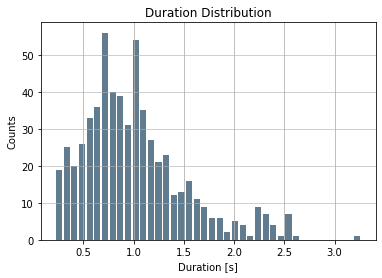

In [11]:
durationDist = pd.Series(np.array(duration))
plt.figure()
durationDist.plot.hist(grid=True, bins=40, rwidth=0.8,
                   color='#607c8e')
plt.title('Duration Distribution')
plt.xlabel('Duration [s]')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)
print("Duration average:",np.mean(duration))

## Short-Time Fourier Transform

In [12]:
show_web("https://en.wikipedia.org/wiki/Short-time_Fourier_transform")

Spectogram Array Shape: (1025, 87)


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


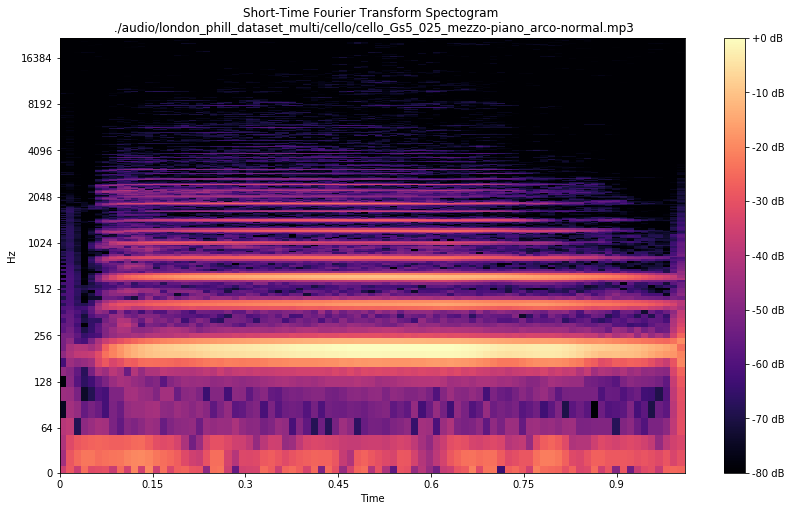

In [13]:
# STFT Example
y, sr = librosa.load(files[10], sr=fs, duration=1)
y/=y.max() #Normalize
duration_in_samples=librosa.time_to_samples(1, sr=fs)
y_pad = librosa.util.fix_length(y, duration_in_samples) #Pad to 1s if smaller
y_stft=librosa.core.stft(y_pad, n_fft=n_fft, hop_length=hop_length)
y_spec=librosa.amplitude_to_db(abs(y_stft), np.max)
plt.figure(figsize=(14,8))
plt.title("Short-Time Fourier Transform Spectogram \n %s"%files[0])
librosa.display.specshow(y_spec,sr=fs,y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB');
print("Spectogram Array Shape:",y_spec.shape)
ipd.Audio(y, rate=fs)

## Encode Labels

In [14]:
# Encode Labels
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

#OneHotEncoding
encoder=OneHotEncoder(sparse=False, categories="auto")
onehot_labels=encoder.fit_transform(classes_num.reshape(len(classes_num),1))

6 classes: cello, flute, oboe, sax, trumpet, viola


## Train and Test Sets

In [15]:
# Create Train and Test Sets
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(files, onehot_labels)
files_arr=np.array(files)

for train_index, test_index in splits:
    train_set_files = files_arr[train_index]
    test_set_files = files_arr[test_index]
    train_classes = onehot_labels[train_index]
    test_classes = onehot_labels[test_index]

## Convolutional Neural Networks

In [16]:
show_web("https://en.wikipedia.org/wiki/Convolutional_neural_network")

## Create Model

In [17]:
# CNN Model
model = Sequential()

conv_filters =  16  # number of convolution filters

# Layer 1
model.add(Convolution2D(conv_filters, 3,input_shape=(1025, 87, 1)))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.40)) 

# Layer 2
model.add(Convolution2D(conv_filters, 3))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

# Flatten
model.add(Flatten()) 

# Full layer
model.add(Dense(16, activation='sigmoid')) 

# Output layer
model.add(Dense(6,activation='softmax'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1023, 85, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 511, 42, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 511, 42, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 509, 40, 16)       2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 254, 20, 16)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 254, 20, 16)       0         
_________________________________________________________________
flatten (Flatten)            (None, 81280)             0

In [19]:
# Loss Function 
loss = 'categorical_crossentropy' 

# Optimizer = Gradient Descent
optimizer = 'sgd' 

# Compile
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

## Train Model

In [20]:
def featureGenerator(files, labels):
    while True:
        for i,f in enumerate(files):
            try:
                feature_vectors = []
                label = []
                y, sr = librosa.load(f, sr=fs)
                if len(y) < 2:
                    print("Error loading %s" % f)
                    continue
                y, index = librosa.effects.trim(y,top_db=60) #Trim
                y = normalize(y)
                duration_in_samples=librosa.time_to_samples(1, sr=fs)
                y_pad = librosa.util.fix_length(y, duration_in_samples) #Pad/Trim to same duration
                y_stft=librosa.core.stft(y_pad, n_fft=n_fft, hop_length=hop_length)
                y_spec=librosa.amplitude_to_db(abs(y_stft), np.min)
                scaler = StandardScaler()
                dtype = K.floatx()
                data = scaler.fit_transform(y_spec).astype(dtype)
                data = np.expand_dims(data, axis=0)
                data = np.expand_dims(data, axis=3)
                feature_vectors.append(data)
                label.append([labels[i]])
                yield feature_vectors, label
            except Exception as e:
                print("Error loading %s. Error: %s" % (f,e))
                raise
                break

In [21]:
%%time
hist = History();
es = EarlyStopping(monitor='val_acc', min_delta=0.01, restore_best_weights=True, patience= 10, verbose=1 )
mc = ModelCheckpoint('best_model.h5', monitor='val_acc',save_best_only=True, verbose=1)


try:
    import google.colab
    tbc=TensorBoardColab()
    callbacksKeras=[hist,es,mc,TensorBoardColabCallback(tbc)]

except Exception as e:
    callbacksKeras=[hist,es,mc]
    print("Not inside Google Colab: %s. Using standard configurations." % (e))


model.fit_generator(featureGenerator(train_set_files, train_classes), 
                    validation_data=(featureGenerator(test_set_files, test_classes)), 
                    validation_steps=150, 
                    steps_per_epoch=450,epochs=30,callbacks=callbacksKeras, verbose=1)

Not inside Google Colab: No module named 'google.colab'. Using standard configurations.
Instructions for updating:
Please use Model.fit, which supports generators.


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


AttributeError: 'History' object has no attribute '_implements_train_batch_hooks'

In [19]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss')
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss')
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

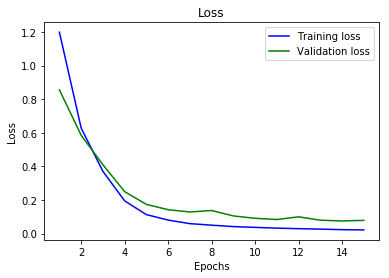

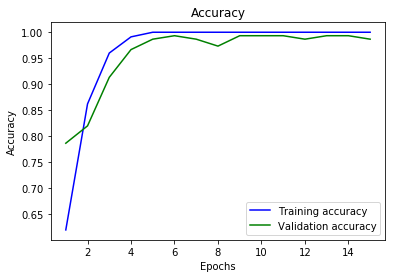

In [20]:
plot_history(hist)

## Evaluate Model

In [21]:
saved_model = load_model('best_model.h5')
test_pred = saved_model.predict_generator(featureGenerator(test_set_files, test_classes), steps=150,verbose=1)

150/150 [==============================] - 18s 118ms/step


In [22]:
predictions_round=np.around(test_pred).astype('int');
predictions_int=np.argmax(predictions_round,axis=1);
predictions_labels=labelencoder.inverse_transform(np.ravel(predictions_int));

In [23]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(classes_num[test_index], predictions_int,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(classes_num[test_index], predictions_int,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(classes_num[test_index], predictions_int, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(classes_num[test_index], predictions_int,normalize=True), accuracy_score(classes_num[test_index], predictions_int,normalize=False) )
print("Number of samples:",classes_num[test_index].shape[0])

print(classification_report(classes_num[test_index], predictions_int))

Recall:  [1.   1.   1.   1.   1.   0.92]
Precision:  [0.96153846 1.         1.         0.96153846 1.         1.        ]
F1-Score:  [0.98039216 1.         1.         0.98039216 1.         0.95833333]
Accuracy: 0.99  , 148
Number of samples: 150
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        25
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        25
           3       0.96      1.00      0.98        25
           4       1.00      1.00      1.00        25
           5       1.00      0.92      0.96        25

   micro avg       0.99      0.99      0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



In [24]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(classes_num[test_index], predictions_int)
np.set_printoptions(precision=2)

In [25]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

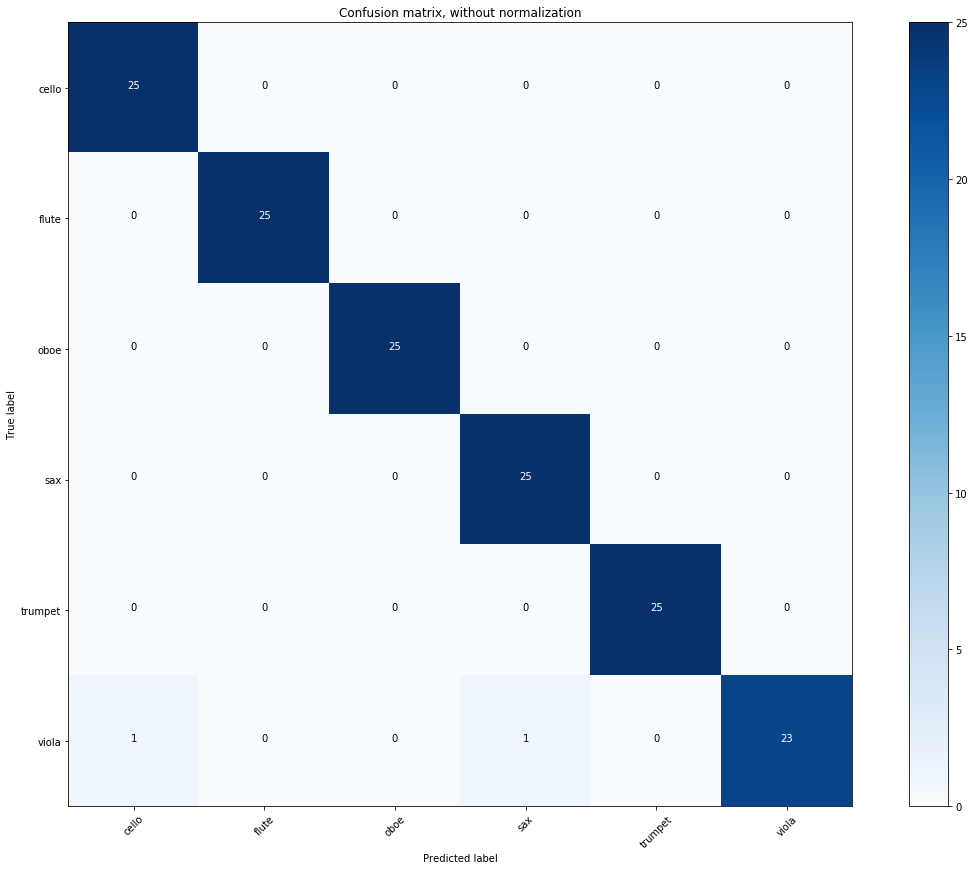

In [26]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [27]:
# Find wrong predicted samples indexes
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(classes_num[test_index], predictions_int)) if e1 != e2]


In [28]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predictions_labels[wrong_predictions].T)
print(np.array(files)[test_index[wrong_predictions]])

['viola' 'viola']
['cello' 'sax']
['./audio/london_phill_dataset_multi/viola/viola_Ds3_05_mezzo-piano_arco-normal.mp3'
 './audio/london_phill_dataset_multi/viola/viola_Gs3_15_piano_arco-normal.mp3']
